# **Optimizing Wind Turbine Fault Detection: Integrating Robust Feature Engineering with Ensemble and Deep Learning Algorithms**

# 1.    Setup & Data Acquisition

## 1.1 Libraries Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import glob
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.decomposition import PCA, TruncatedSVD
from mpl_toolkits.mplot3d import Axes3D

## 1.2 Data Loading

In [2]:
current_dir = os.getcwd()
base_path = os.path.join(current_dir, 'dataset', 'Wind Farm A')
dataset_path = os.path.join(base_path, 'datasets')
event_info_path = os.path.join(base_path, 'event_info.csv')

In [3]:
all_data_list = []
csv_files = glob.glob(os.path.join(dataset_path, "*.csv"))
print(f"{len(csv_files)} files.")

22 files.


In [4]:
for file in csv_files:
    df_temp = pd.read_csv(file, sep=';')
    name = file.split('/')[-1]
    id = name.split('.')[0]
    df_temp['event_id'] = int(id)
    
    all_data_list.append(df_temp)

big_df = pd.concat(all_data_list)
big_df

time_stamp  asset_id     id  train_test  status_type_id  \
0      2022-07-28 13:20:00        11      0       train               0   
1      2022-07-28 13:30:00        11      1       train               0   
2      2022-07-28 13:40:00        11      2       train               0   
3      2022-07-28 13:50:00        11      3       train               0   
4      2022-07-28 14:00:00        11      4       train               0   
...                    ...       ...    ...         ...             ...   
54739  2023-01-17 23:20:00         0  54739  prediction               0   
54740  2023-01-17 23:30:00         0  54740  prediction               0   
54741  2023-01-17 23:40:00         0  54741  prediction               0   
54742  2023-01-17 23:50:00         0  54742  prediction               0   
54743  2023-01-18 00:00:00         0  54743  prediction               0   

       sensor_0_avg  sensor_1_avg  sensor_2_avg  wind_speed_3_avg  \
0              31.0         152.0          48.7               3.9   
1              31.0          86.1         150.9               6.0   
2              31.0         115.2          69.6               6.3   
3              32.0         129.3         -29.1               6.0   
4              32.0         137.7          26.4               7.1   
...             ...           ...           ...               ...   
54739          12.0         314.6         -24.0               3.4   
54740          12.0         345.5           7.6               4.0   
54741          13.0         343.1          -2.1               4.1   
54742          13.0         331.5         -13.7               3.5   
54743          12.0         342.7          -2.5               2.9   

       wind_speed_4_avg  ...  sensor_48  sensor_49  sensor_50  sensor_51  \
0                   3.9  ...        0.0        0.0    -1185.0    -2090.0   
1                   6.0  ...        0.0        0.0    -1050.0    -1627.0   
2                   6.3  ...        0.0        0.0    -1043.0    -1624.0   
3                   5.9  ...    -9540.0        0.0    40124.0    -9753.0   
4                   6.9  ...   -25215.0        0.0    99360.0   -25215.0   
...                 ...  ...        ...        ...        ...        ...   
54739               3.5  ...     -570.0        0.0     2299.0    -1209.0   
54740               4.0  ...    -7757.0        0.0     9430.0    -7792.0   
54741               4.0  ...   -25888.0        0.0    10201.0   -25888.0   
54742               3.6  ...   -13529.0        0.0     4231.0   -13549.0   
54743               2.9  ...        0.0        0.0    -1590.0    -1758.0   

       sensor_52_avg  sensor_52_max  sensor_52_min  sensor_52_std  \
0                0.4            2.6            0.0            0.8   
1                0.0            0.0            0.0            0.0   
2                0.0            0.0            0.0            0.0   
3                9.5           14.0            0.0            4.8   
4               13.1           14.9           10.8            1.3   
...              ...            ...            ...            ...   
54739           10.3           11.2            1.9            2.5   
54740            9.3           12.1            2.5            3.4   
54741           11.1           11.1           11.0            0.0   
54742           11.1           11.1           11.0            0.0   
54743            4.1           11.1            1.9            3.5   

       sensor_53_avg  event_id  
0               34.0        68  
1               34.0        68  
2               34.0        68  
3               34.0        68  
4               35.0        68  
...              ...       ...  
54739           15.0        71  
54740           15.0        71  
54741           15.0        71  
54742           15.0        71  
54743           15.0        71  

[1196747 rows x 87 columns]

In [5]:
event_info = pd.read_csv(event_info_path, sep=';')
event_labels = event_info[['event_id', 'event_label', 'event_description']]
event_labels['event_id'] = event_labels['event_id'].astype(int)
print(event_labels.head(3))

   event_id event_label    event_description
0        68     anomaly  Transformer failure
1        22     anomaly      Hydraulic group
2        72     anomaly      Gearbox failure


/var/folders/q3/r_v4tt3n0hqb53bp2w2dg2hm0000gn/T/ipykernel_35837/2462733868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_labels['event_id'] = event_labels['event_id'].astype(int)


In [6]:
big_df = pd.merge(big_df, event_labels, on='event_id', how='left')
big_df.head()

time_stamp  asset_id  id train_test  status_type_id  sensor_0_avg  \
0  2022-07-28 13:20:00        11   0      train               0          31.0   
1  2022-07-28 13:30:00        11   1      train               0          31.0   
2  2022-07-28 13:40:00        11   2      train               0          31.0   
3  2022-07-28 13:50:00        11   3      train               0          32.0   
4  2022-07-28 14:00:00        11   4      train               0          32.0   

   sensor_1_avg  sensor_2_avg  wind_speed_3_avg  wind_speed_4_avg  ...  \
0         152.0          48.7               3.9               3.9  ...   
1          86.1         150.9               6.0               6.0  ...   
2         115.2          69.6               6.3               6.3  ...   
3         129.3         -29.1               6.0               5.9  ...   
4         137.7          26.4               7.1               6.9  ...   

   sensor_50  sensor_51  sensor_52_avg  sensor_52_max  sensor_52_min  \
0    -1185.0    -2090.0            0.4            2.6            0.0   
1    -1050.0    -1627.0            0.0            0.0            0.0   
2    -1043.0    -1624.0            0.0            0.0            0.0   
3    40124.0    -9753.0            9.5           14.0            0.0   
4    99360.0   -25215.0           13.1           14.9           10.8   

   sensor_52_std  sensor_53_avg  event_id  event_label    event_description  
0            0.8           34.0        68      anomaly  Transformer failure  
1            0.0           34.0        68      anomaly  Transformer failure  
2            0.0           34.0        68      anomaly  Transformer failure  
3            4.8           34.0        68      anomaly  Transformer failure  
4            1.3           35.0        68      anomaly  Transformer failure  

[5 rows x 89 columns]

## 1.3 Basic Inspection

In [7]:
big_df.head()

time_stamp  asset_id  id train_test  status_type_id  sensor_0_avg  \
0  2022-07-28 13:20:00        11   0      train               0          31.0   
1  2022-07-28 13:30:00        11   1      train               0          31.0   
2  2022-07-28 13:40:00        11   2      train               0          31.0   
3  2022-07-28 13:50:00        11   3      train               0          32.0   
4  2022-07-28 14:00:00        11   4      train               0          32.0   

   sensor_1_avg  sensor_2_avg  wind_speed_3_avg  wind_speed_4_avg  ...  \
0         152.0          48.7               3.9               3.9  ...   
1          86.1         150.9               6.0               6.0  ...   
2         115.2          69.6               6.3               6.3  ...   
3         129.3         -29.1               6.0               5.9  ...   
4         137.7          26.4               7.1               6.9  ...   

   sensor_50  sensor_51  sensor_52_avg  sensor_52_max  sensor_52_min  \
0    -1185.0    -2090.0            0.4            2.6            0.0   
1    -1050.0    -1627.0            0.0            0.0            0.0   
2    -1043.0    -1624.0            0.0            0.0            0.0   
3    40124.0    -9753.0            9.5           14.0            0.0   
4    99360.0   -25215.0           13.1           14.9           10.8   

   sensor_52_std  sensor_53_avg  event_id  event_label    event_description  
0            0.8           34.0        68      anomaly  Transformer failure  
1            0.0           34.0        68      anomaly  Transformer failure  
2            0.0           34.0        68      anomaly  Transformer failure  
3            4.8           34.0        68      anomaly  Transformer failure  
4            1.3           35.0        68      anomaly  Transformer failure  

[5 rows x 89 columns]

In [8]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196747 entries, 0 to 1196746
Data columns (total 89 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   time_stamp             1196747 non-null  object 
 1   asset_id               1196747 non-null  int64  
 2   id                     1196747 non-null  int64  
 3   train_test             1196747 non-null  object 
 4   status_type_id         1196747 non-null  int64  
 5   sensor_0_avg           1196747 non-null  float64
 6   sensor_1_avg           1196747 non-null  float64
 7   sensor_2_avg           1196747 non-null  float64
 8   wind_speed_3_avg       1196747 non-null  float64
 9   wind_speed_4_avg       1196747 non-null  float64
 10  wind_speed_3_max       1196747 non-null  float64
 11  wind_speed_3_min       1196747 non-null  float64
 12  wind_speed_3_std       1196747 non-null  float64
 13  sensor_5_avg           1196747 non-null  float64
 14  sensor_5_max      

In [9]:
big_df.describe()

asset_id            id  status_type_id  sensor_0_avg  sensor_1_avg  \
count  1.196747e+06  1.196747e+06    1.196747e+06  1.196747e+06  1.196747e+06   
mean   1.042951e+01  2.720275e+04    4.582046e-01  1.995072e+01  1.708527e+02   
std    6.796280e+00  1.571098e+04    1.250394e+00  5.555743e+00  9.258916e+01   
min    0.000000e+00  0.000000e+00    0.000000e+00  4.000000e+00  0.000000e+00   
25%    1.000000e+01  1.359900e+04    0.000000e+00  1.600000e+01  9.790000e+01   
50%    1.100000e+01  2.719800e+04    0.000000e+00  1.900000e+01  1.294000e+02   
75%    1.300000e+01  4.079800e+04    0.000000e+00  2.400000e+01  2.601000e+02   
max    2.100000e+01  5.615700e+04    4.000000e+00  4.100000e+01  3.590000e+02   

       sensor_2_avg  wind_speed_3_avg  wind_speed_4_avg  wind_speed_3_max  \
count  1.196747e+06      1.196747e+06      1.196747e+06      1.196747e+06   
mean   1.270151e-01      6.201962e+00      6.151001e+00      1.269426e+01   
std    3.276378e+01      3.730365e+00      3.623949e+00      7.420963e+00   
min   -1.800000e+02      4.000000e-01      0.000000e+00      4.000000e-01   
25%   -9.700000e+00      3.200000e+00      3.200000e+00      6.900000e+00   
50%    2.000000e-01      5.500000e+00      5.500000e+00      1.100000e+01   
75%    9.300000e+00      8.500000e+00      8.400000e+00      1.770000e+01   
max    1.800000e+02      2.660000e+01      2.660000e+01      7.000000e+01   

       wind_speed_3_min  ...     sensor_48  sensor_49     sensor_50  \
count      1.196747e+06  ...  1.196747e+06  1196747.0  1.196747e+06   
mean       1.763252e+00  ... -1.588284e+04        0.0  9.304541e+04   
std        1.227410e+00  ...  1.361794e+04        0.0  1.135679e+05   
min        4.000000e-01  ... -9.847500e+04        0.0 -5.367000e+03   
25%        7.000000e-01  ... -2.838500e+04        0.0 -5.610000e+02   
50%        1.500000e+00  ... -1.626300e+04        0.0  3.882700e+04   
75%        2.500000e+00  ...  0.000000e+00        0.0  1.611880e+05   
max        1.460000e+01  ...  1.668060e+05        0.0  3.712560e+05   

          sensor_51  sensor_52_avg  sensor_52_max  sensor_52_min  \
count  1.196747e+06   1.196747e+06   1.196747e+06   1.196747e+06   
mean  -1.627345e+04   9.410091e+00   1.049616e+01   8.237345e+00   
std    1.318826e+04   5.565728e+00   5.759044e+00   5.572132e+00   
min   -9.847500e+04   0.000000e+00   0.000000e+00   0.000000e+00   
25%   -2.838600e+04   2.400000e+00   2.800000e+00   1.700000e+00   
50%   -1.627100e+04   1.140000e+01   1.270000e+01   1.090000e+01   
75%   -1.855000e+03   1.420000e+01   1.490000e+01   1.230000e+01   
max    1.668060e+05   1.490000e+01   1.960000e+01   1.480000e+01   

       sensor_52_std  sensor_53_avg      event_id  
count   1.196747e+06   1.196747e+06  1.196747e+06  
mean    6.089519e-01   2.278092e+01  4.080538e+01  
std     9.986380e-01   5.949853e+00  2.719184e+01  
min     0.000000e+00   6.000000e+00  0.000000e+00  
25%     1.000000e-01   1.800000e+01  1.700000e+01  
50%     3.000000e-01   2.200000e+01  3.800000e+01  
75%     7.000000e-01   2.700000e+01  6.900000e+01  
max     7.400000e+00   4.700000e+01  9.200000e+01  

[8 rows x 85 columns]

In [10]:
print("===== DATA OVERVIEW =====")
print(f"Total rows: {big_df.shape[0]}")
print(f"Total columns: {big_df.shape[1]}")

print(f"Number of unique events: {big_df['event_id'].nunique()}")
if 'asset_id' in big_df.columns:
    print(f"Number of unique assets: {big_df['asset_id'].nunique()}")

label_counts = big_df['event_label'].value_counts(dropna=False)
print("\nEvent label distribution (raw data):")
print(label_counts)
print("Ratio (anomaly / normal):",
      round(label_counts.get(1,0) / label_counts.get(0,1e-9), 3))

data_quality = pd.DataFrame({
    "dtype": big_df.dtypes,
    "n_missing": big_df.isna().sum(),
    "missing_pct": big_df.isna().mean().round(4),
    "n_unique": big_df.nunique()
}).sort_values("missing_pct", ascending=False)

display(data_quality.head(15))


===== DATA OVERVIEW =====
Total rows: 1196747
Total columns: 89
Number of unique events: 22
Number of unique assets: 5

Event label distribution (raw data):
event_label
anomaly    649789
normal     546958
Name: count, dtype: int64
Ratio (anomaly / normal): 0.842


/var/folders/q3/r_v4tt3n0hqb53bp2w2dg2hm0000gn/T/ipykernel_35837/158031222.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  round(label_counts.get(1,0) / label_counts.get(0,1e-9), 3))


dtype  n_missing  missing_pct  n_unique
event_description       object     546958        0.457         5
reactive_power_28_avg  float64          0        0.000     10000
sensor_36_avg          float64          0        0.000        35
sensor_35_avg          float64          0        0.000        36
sensor_34_avg          float64          0        0.000       237
sensor_33_avg          float64          0        0.000       214
sensor_32_avg          float64          0        0.000       223
sensor_31_std          float64          0        0.000      3631
sensor_31_min          float64          0        0.000      9195
sensor_31_max          float64          0        0.000     11400
sensor_31_avg          float64          0        0.000      3600
power_30_std           float64          0        0.000      5977
power_30_min           float64          0        0.000     20391
power_30_max           float64          0        0.000     21377
power_30_avg           float64          0        0.000     20303

You can /CARE_To_Compare/Wind Farm A/event_info.csv and feature_description.csv to know more 

# 2.    Data Preprocessing 

## 2.1 Data Cleaning

### handle missing values

In [11]:
big_df.isnull().sum().sort_values(ascending=False)

event_description        546958
sensor_14_avg                20
sensor_22_avg                20
sensor_31_avg                 0
sensor_35_avg                 0
                          ...  
sensor_17_avg                 0
sensor_16_avg                 0
sensor_15_avg                 0
sensor_13_avg                 0
reactive_power_27_std         0
Length: 89, dtype: int64

sensor_14;average;Temperature in generator bearing 1 (Non-Drive End)
sensor_22;average;Actual phase displacement
since there is few missing values in these columns, we can fill them with mean values
event_description is not necessary for our model, so we can drop it

In [12]:
big_df['sensor_14_avg'].fillna(big_df['sensor_14_avg'].mean(), inplace=True)
big_df['sensor_22_avg'].fillna(big_df['sensor_22_avg'].mean(), inplace=True)
big_df.drop(columns=['event_description'], inplace=True)

/var/folders/q3/r_v4tt3n0hqb53bp2w2dg2hm0000gn/T/ipykernel_35837/1552890537.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  big_df['sensor_14_avg'].fillna(big_df['sensor_14_avg'].mean(), inplace=True)
/var/folders/q3/r_v4tt3n0hqb53bp2w2dg2hm0000gn/T/ipykernel_35837/1552890537.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whic

In [13]:
big_df.isnull().sum().sort_values(ascending=False)

time_stamp       0
asset_id         0
sensor_35_avg    0
sensor_34_avg    0
sensor_33_avg    0
                ..
sensor_16_avg    0
sensor_15_avg    0
sensor_14_avg    0
sensor_13_avg    0
event_label      0
Length: 88, dtype: int64

### Physics-based Cleaning

From ```big_df.describe()``` we can see ``sensor_49``(Reactive power - generator connected in star) is all 0, could be dropped since it is not useful to the model 

In [14]:
big_df = big_df.drop(columns=['sensor_49'])

## 2.2 Label Engineering

Labeling (Key Step): Detailed description of how "fault samples" are defined (e.g., using Status Codes or maintenance logs to label the 24 hours preceding a fault as 1, and normal operation as 0).

In [15]:
#mapping
mapping = {
    'normal': 0,
    'anomaly': 1
}
big_df['event_label'] = big_df['event_label'].map(mapping)
big_df

time_stamp  asset_id     id  train_test  status_type_id  \
0        2022-07-28 13:20:00        11      0       train               0   
1        2022-07-28 13:30:00        11      1       train               0   
2        2022-07-28 13:40:00        11      2       train               0   
3        2022-07-28 13:50:00        11      3       train               0   
4        2022-07-28 14:00:00        11      4       train               0   
...                      ...       ...    ...         ...             ...   
1196742  2023-01-17 23:20:00         0  54739  prediction               0   
1196743  2023-01-17 23:30:00         0  54740  prediction               0   
1196744  2023-01-17 23:40:00         0  54741  prediction               0   
1196745  2023-01-17 23:50:00         0  54742  prediction               0   
1196746  2023-01-18 00:00:00         0  54743  prediction               0   

         sensor_0_avg  sensor_1_avg  sensor_2_avg  wind_speed_3_avg  \
0                31.0         152.0          48.7               3.9   
1                31.0          86.1         150.9               6.0   
2                31.0         115.2          69.6               6.3   
3                32.0         129.3         -29.1               6.0   
4                32.0         137.7          26.4               7.1   
...               ...           ...           ...               ...   
1196742          12.0         314.6         -24.0               3.4   
1196743          12.0         345.5           7.6               4.0   
1196744          13.0         343.1          -2.1               4.1   
1196745          13.0         331.5         -13.7               3.5   
1196746          12.0         342.7          -2.5               2.9   

         wind_speed_4_avg  ...  sensor_48  sensor_50  sensor_51  \
0                     3.9  ...        0.0    -1185.0    -2090.0   
1                     6.0  ...        0.0    -1050.0    -1627.0   
2                     6.3  ...        0.0    -1043.0    -1624.0   
3                     5.9  ...    -9540.0    40124.0    -9753.0   
4                     6.9  ...   -25215.0    99360.0   -25215.0   
...                   ...  ...        ...        ...        ...   
1196742               3.5  ...     -570.0     2299.0    -1209.0   
1196743               4.0  ...    -7757.0     9430.0    -7792.0   
1196744               4.0  ...   -25888.0    10201.0   -25888.0   
1196745               3.6  ...   -13529.0     4231.0   -13549.0   
1196746               2.9  ...        0.0    -1590.0    -1758.0   

         sensor_52_avg  sensor_52_max  sensor_52_min  sensor_52_std  \
0                  0.4            2.6            0.0            0.8   
1                  0.0            0.0            0.0            0.0   
2                  0.0            0.0            0.0            0.0   
3                  9.5           14.0            0.0            4.8   
4                 13.1           14.9           10.8            1.3   
...                ...            ...            ...            ...   
1196742           10.3           11.2            1.9            2.5   
1196743            9.3           12.1            2.5            3.4   
1196744           11.1           11.1           11.0            0.0   
1196745           11.1           11.1           11.0            0.0   
1196746            4.1           11.1            1.9            3.5   

         sensor_53_avg  event_id  event_label  
0                 34.0        68            1  
1                 34.0        68            1  
2                 34.0        68            1  
3                 34.0        68            1  
4                 35.0        68            1  
...                ...       ...          ...  
1196742           15.0        71            0  
1196743           15.0        71            0  
1196744           15.0        71            0  
1196745           15.0        71            0  
1196746           15.0        71            0  

[1196

In [16]:
big_df.select_dtypes(include=['object']).columns

Index(['time_stamp', 'train_test'], dtype='object')

we dont need id to train our model hence we drop `time_stamp`, `asset_id`, `id`, `status_type_id`, `event_id` , `event_description` columns.
including it would allow the model to trivially classify anomalies without learning the underlying physical precursors (e.g., overheating or vibration patterns) recorded by the sensors.


In [17]:
df = big_df.drop(columns=['time_stamp', 'asset_id', 'id', 'status_type_id', 'event_id'])
df

train_test  sensor_0_avg  sensor_1_avg  sensor_2_avg  \
0             train          31.0         152.0          48.7   
1             train          31.0          86.1         150.9   
2             train          31.0         115.2          69.6   
3             train          32.0         129.3         -29.1   
4             train          32.0         137.7          26.4   
...             ...           ...           ...           ...   
1196742  prediction          12.0         314.6         -24.0   
1196743  prediction          12.0         345.5           7.6   
1196744  prediction          13.0         343.1          -2.1   
1196745  prediction          13.0         331.5         -13.7   
1196746  prediction          12.0         342.7          -2.5   

         wind_speed_3_avg  wind_speed_4_avg  wind_speed_3_max  \
0                     3.9               3.9               8.0   
1                     6.0               6.0               9.9   
2                     6.3               6.3              10.6   
3                     6.0               5.9              12.4   
4                     7.1               6.9              13.7   
...                   ...               ...               ...   
1196742               3.4               3.5               7.7   
1196743               4.0               4.0              17.2   
1196744               4.1               4.0               7.0   
1196745               3.5               3.6               7.3   
1196746               2.9               2.9               6.7   

         wind_speed_3_min  wind_speed_3_std  sensor_5_avg  ...  sensor_47  \
0                     0.6               0.9          70.5  ...    -2090.0   
1                     0.6               1.4          86.0  ...    -1627.0   
2                     0.8               1.3          86.0  ...    -1624.0   
3                     1.7               1.4          13.6  ...     -212.0   
4                     1.7               1.7          -1.9  ...        0.0   
...                   ...               ...           ...  ...        ...   
1196742               0.5               0.8           3.5  ...     -639.0   
1196743               1.4               0.8           4.1  ...      -35.0   
1196744               0.9               0.6          -0.3  ...        0.0   
1196745               0.4               0.7           0.4  ...      -20.0   
1196746               0.4               0.8          20.3  ...    -1758.0   

         sensor_48  sensor_50  sensor_51  sensor_52_avg  sensor_52_max  \
0              0.0    -1185.0    -2090.0            0.4            2.6   
1              0.0    -1050.0    -1627.0            0.0            0.0   
2              0.0    -1043.0    -1624.0            0.0            0.0   
3          -9540.0    40124.0    -9753.0            9.5           14.0   
4         -25215.0    99360.0   -25215.0           13.1           14.9   
...            ...        ...        ...            ...            ...   
1196742     -570.0     2299.0    -1209.0           10.3           11.2   
1196743    -7757.0     9430.0    -7792.0            9.3           12.1   
1196744   -25888.0    10201.0   -25888.0           11.1           11.1   
1196745   -13529.0     4231.0   -13549.0           11.1           11.1   
1196746        0.0    -1590.0    -1758.0            4.1           11.1   

         sensor_52_min  sensor_52_std  sensor_53_avg  event_label  
0                  0.0            0.8           34.0            1  
1                  0.0            0.0           34.0            1  
2                  0.0            0.0           34.0            1  
3                  0.0            4.8           34.0            1  
4                 10.8            1.3           35.0            1  
...                ...            ...            ...          ...  
1196742            1.9            2.5           15.0            0  
1196743            2.5            3.4           15.0            0  
1196744           11.

**Speicial note**: From README, ``train_test``: Strings describing whether the timestamp is part of the prediction data or the training data of the dataset. This is for time-series cross-validation purposes. however our project is aiming to detect anomalies rather than time-series forecasting, so we can drop this column as well. We are going to use ``prediction`` part, which is balanced between normal and anomaly events from Dataset Description.

In [18]:
df = df[df['train_test']=='prediction']
df

train_test  sensor_0_avg  sensor_1_avg  sensor_2_avg  \
52063    prediction          31.0         253.1          -0.4   
52064    prediction          30.0         287.1          18.4   
52065    prediction          30.0         301.6          33.3   
52066    prediction          30.0         259.0          -9.3   
52067    prediction          30.0         295.8          19.8   
...             ...           ...           ...           ...   
1196742  prediction          12.0         314.6         -24.0   
1196743  prediction          12.0         345.5           7.6   
1196744  prediction          13.0         343.1          -2.1   
1196745  prediction          13.0         331.5         -13.7   
1196746  prediction          12.0         342.7          -2.5   

         wind_speed_3_avg  wind_speed_4_avg  wind_speed_3_max  \
52063                 5.6               5.4              10.8   
52064                 5.7               5.6              11.4   
52065                 6.3               6.2              12.4   
52066                 6.3               6.1              13.3   
52067                 5.7               5.6              12.4   
...                   ...               ...               ...   
1196742               3.4               3.5               7.7   
1196743               4.0               4.0              17.2   
1196744               4.1               4.0               7.0   
1196745               3.5               3.6               7.3   
1196746               2.9               2.9               6.7   

         wind_speed_3_min  wind_speed_3_std  sensor_5_avg  ...  sensor_47  \
52063                 2.1               1.0          -1.5  ...        0.0   
52064                 2.1               1.1          -1.5  ...        0.0   
52065                 2.7               1.2          -1.8  ...        0.0   
52066                 2.5               1.0          -1.9  ...        0.0   
52067                 1.5               1.1          -1.6  ...        0.0   
...                   ...               ...           ...  ...        ...   
1196742               0.5               0.8           3.5  ...     -639.0   
1196743               1.4               0.8           4.1  ...      -35.0   
1196744               0.9               0.6          -0.3  ...        0.0   
1196745               0.4               0.7           0.4  ...      -20.0   
1196746               0.4               0.8          20.3  ...    -1758.0   

         sensor_48  sensor_50  sensor_51  sensor_52_avg  sensor_52_max  \
52063     -36200.0    41983.0   -36200.0           11.6           12.9   
52064     -17412.0    45924.0   -17412.0           11.7           13.9   
52065     -18263.0    65606.0   -18263.0           12.4           14.2   
52066     -15416.0    60958.0   -15416.0           12.3           14.0   
52067     -17597.0    47856.0   -17597.0           11.8           13.0   
...            ...        ...        ...            ...            ...   
1196742     -570.0     2299.0    -1209.0           10.3           11.2   
1196743    -7757.0     9430.0    -7792.0            9.3           12.1   
1196744   -25888.0    10201.0   -25888.0           11.1           11.1   
1196745   -13529.0     4231.0   -13549.0           11.1           11.1   
1196746        0.0    -1590.0    -1758.0            4.1           11.1   

         sensor_52_min  sensor_52_std  sensor_53_avg  event_label  
52063             10.9            0.5           36.0            1  
52064             10.9            0.7           35.0            1  
52065             11.0            0.9           35.0            1  
52066             11.2            0.6           35.0            1  
52067             10.9            0.5           35.0            1  
...                ...            ...            ...          ...  
1196742            1.9            2.5           15.0            0  
1196743            2.5            3.4           15.0            0  
1196744           11.

In [19]:
df = df.drop(columns = ['train_test'])
df

sensor_0_avg  sensor_1_avg  sensor_2_avg  wind_speed_3_avg  \
52063            31.0         253.1          -0.4               5.6   
52064            30.0         287.1          18.4               5.7   
52065            30.0         301.6          33.3               6.3   
52066            30.0         259.0          -9.3               6.3   
52067            30.0         295.8          19.8               5.7   
...               ...           ...           ...               ...   
1196742          12.0         314.6         -24.0               3.4   
1196743          12.0         345.5           7.6               4.0   
1196744          13.0         343.1          -2.1               4.1   
1196745          13.0         331.5         -13.7               3.5   
1196746          12.0         342.7          -2.5               2.9   

         wind_speed_4_avg  wind_speed_3_max  wind_speed_3_min  \
52063                 5.4              10.8               2.1   
52064                 5.6              11.4               2.1   
52065                 6.2              12.4               2.7   
52066                 6.1              13.3               2.5   
52067                 5.6              12.4               1.5   
...                   ...               ...               ...   
1196742               3.5               7.7               0.5   
1196743               4.0              17.2               1.4   
1196744               4.0               7.0               0.9   
1196745               3.6               7.3               0.4   
1196746               2.9               6.7               0.4   

         wind_speed_3_std  sensor_5_avg  sensor_5_max  ...  sensor_47  \
52063                 1.0          -1.5          -0.3  ...        0.0   
52064                 1.1          -1.5          -0.4  ...        0.0   
52065                 1.2          -1.8          -0.3  ...        0.0   
52066                 1.0          -1.9          -1.0  ...        0.0   
52067                 1.1          -1.6          -0.2  ...        0.0   
...                   ...           ...           ...  ...        ...   
1196742               0.8           3.5          47.2  ...     -639.0   
1196743               0.8           4.1          24.0  ...      -35.0   
1196744               0.6          -0.3           0.4  ...        0.0   
1196745               0.7           0.4           1.5  ...      -20.0   
1196746               0.8          20.3          46.4  ...    -1758.0   

         sensor_48  sensor_50  sensor_51  sensor_52_avg  sensor_52_max  \
52063     -36200.0    41983.0   -36200.0           11.6           12.9   
52064     -17412.0    45924.0   -17412.0           11.7           13.9   
52065     -18263.0    65606.0   -18263.0           12.4           14.2   
52066     -15416.0    60958.0   -15416.0           12.3           14.0   
52067     -17597.0    47856.0   -17597.0           11.8           13.0   
...            ...        ...        ...            ...            ...   
1196742     -570.0     2299.0    -1209.0           10.3           11.2   
1196743    -7757.0     9430.0    -7792.0            9.3           12.1   
1196744   -25888.0    10201.0   -25888.0           11.1           11.1   
1196745   -13529.0     4231.0   -13549.0           11.1           11.1   
1196746        0.0    -1590.0    -1758.0            4.1           11.1   

         sensor_52_min  sensor_52_std  sensor_53_avg  event_label  
52063             10.9            0.5           36.0            1  
52064             10.9            0.7           35.0            1  
52065             11.0            0.9           35.0            1  
52066             11.2            0.6           35.0            1  
52067             10.9            0.5           35.0            1  
...                ...            ...            ...          ...  
1196742            1.9            2.5           15.0            0  
1196743            2.5            3.4           15.0            0

In [20]:
df['event_label'].value_counts()

event_label
0    26064
1    24529
Name: count, dtype: int64

**This is important! shows that our data is balanced**

## 2.3 Train/Test Split

We do train/test split after data preprocessing to avoid data leakage.

In [21]:
df_feature = df.drop(columns =['event_label'])
df_target = df['event_label']

In [22]:
# 20% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(
df_feature, df_target, test_size=0.2, random_state=1)

# 3.	Exploratory Data Analysis

## 3.1 Univariate Analysis

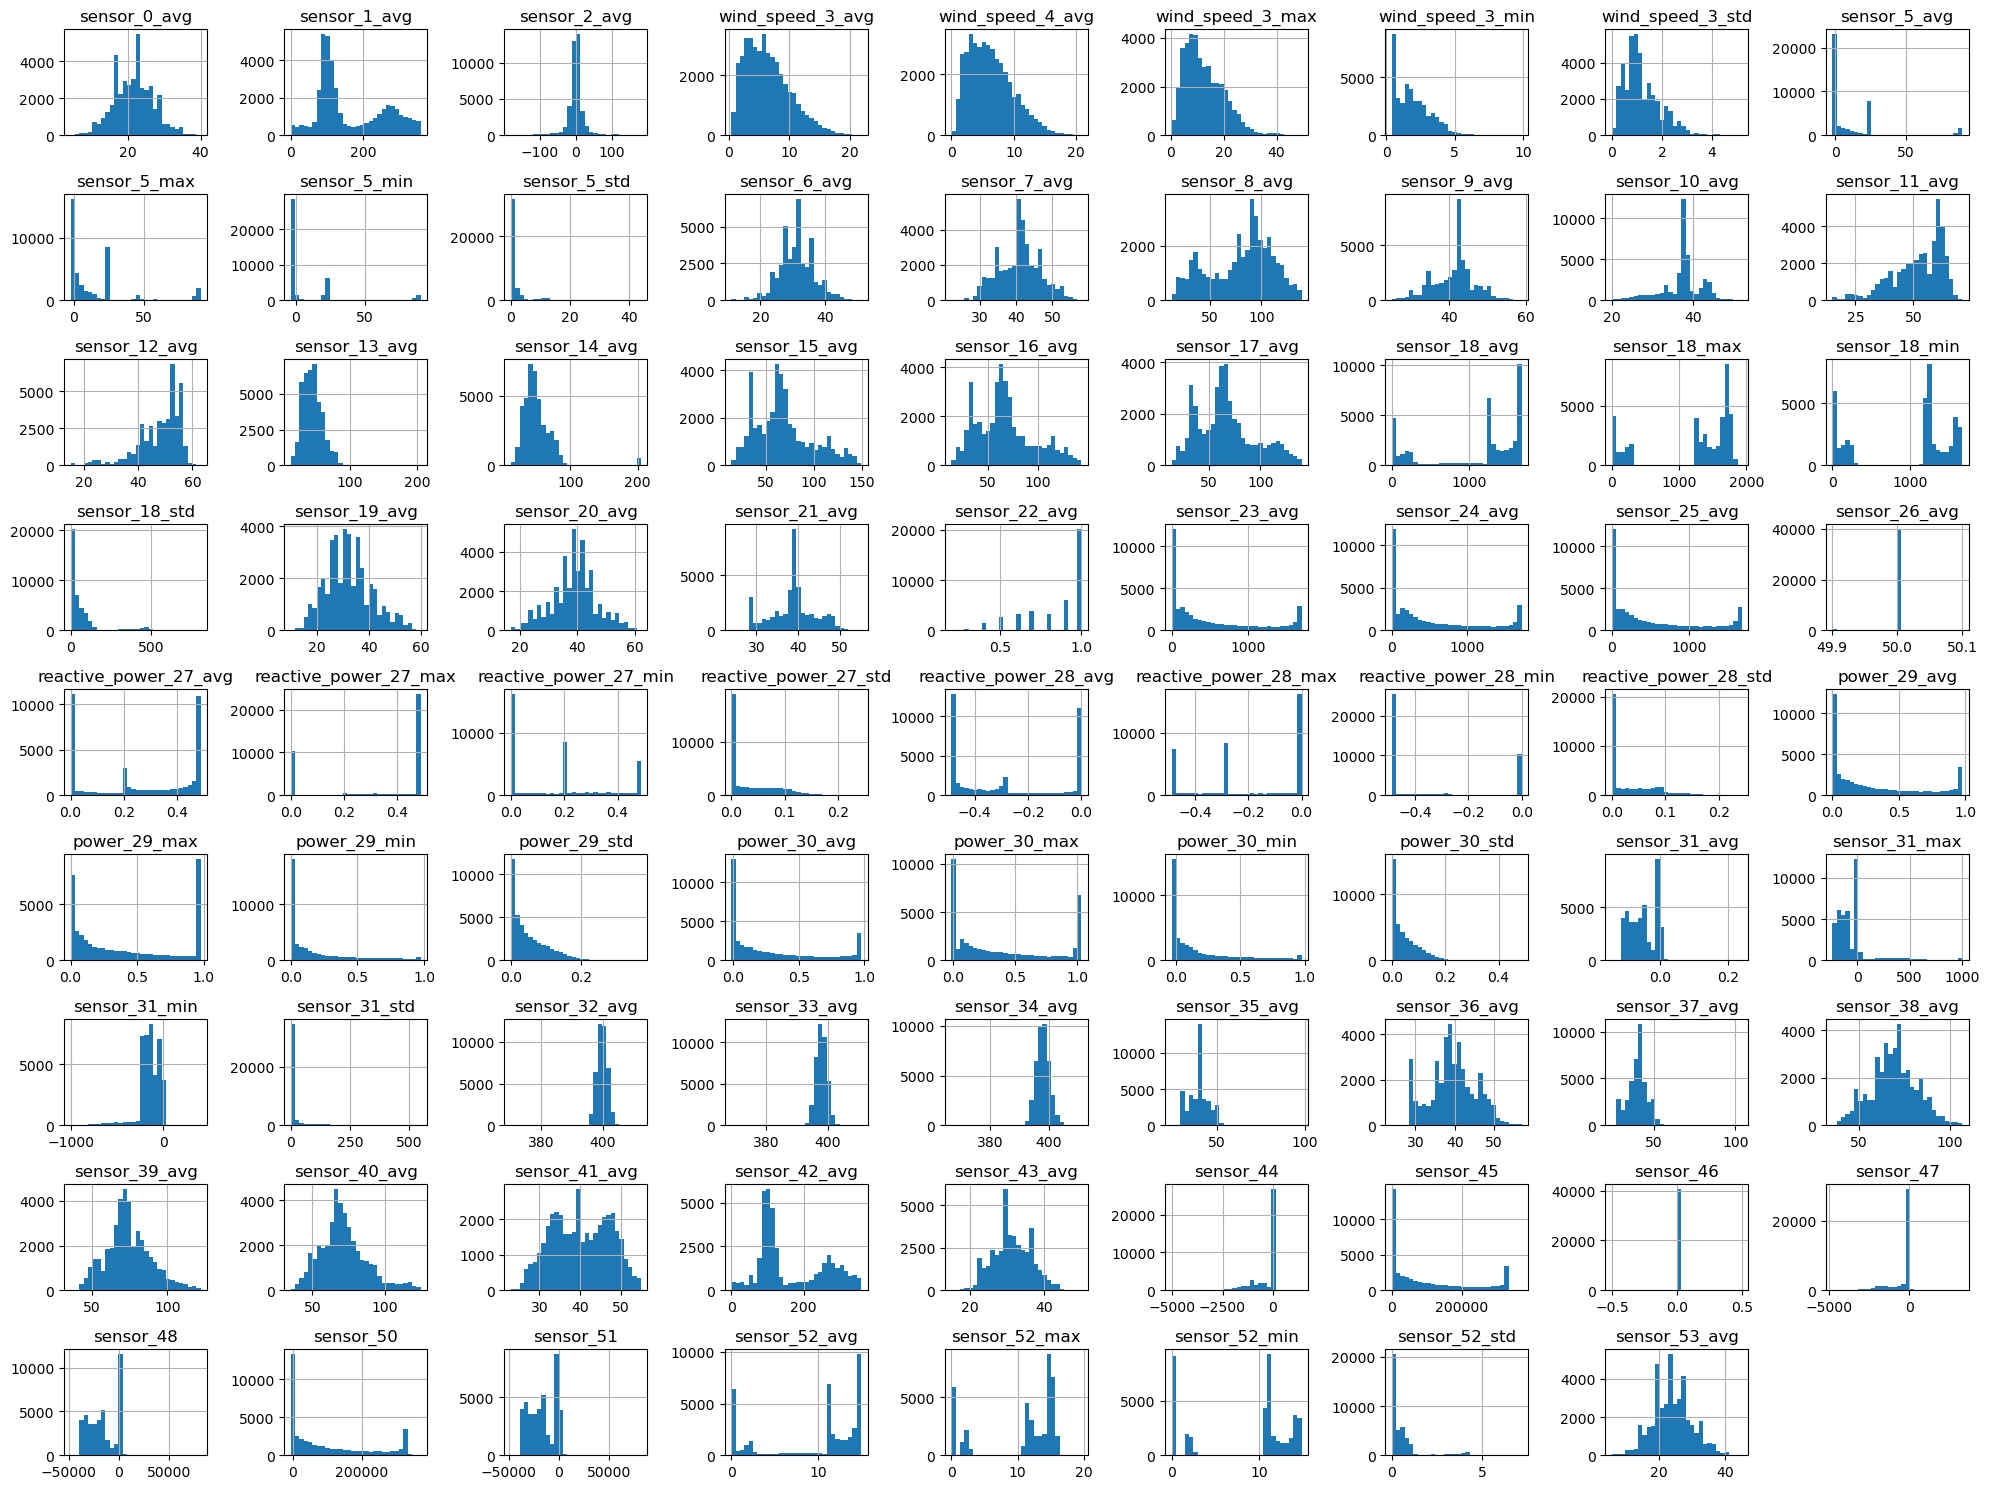

In [23]:
X_train.hist(bins=30, figsize=(20,15))
plt.tight_layout()
plt.show()

not gonna use this graph since it is not beatiful enough

And you can see the following code for plotting all features' distribution with different color for different label

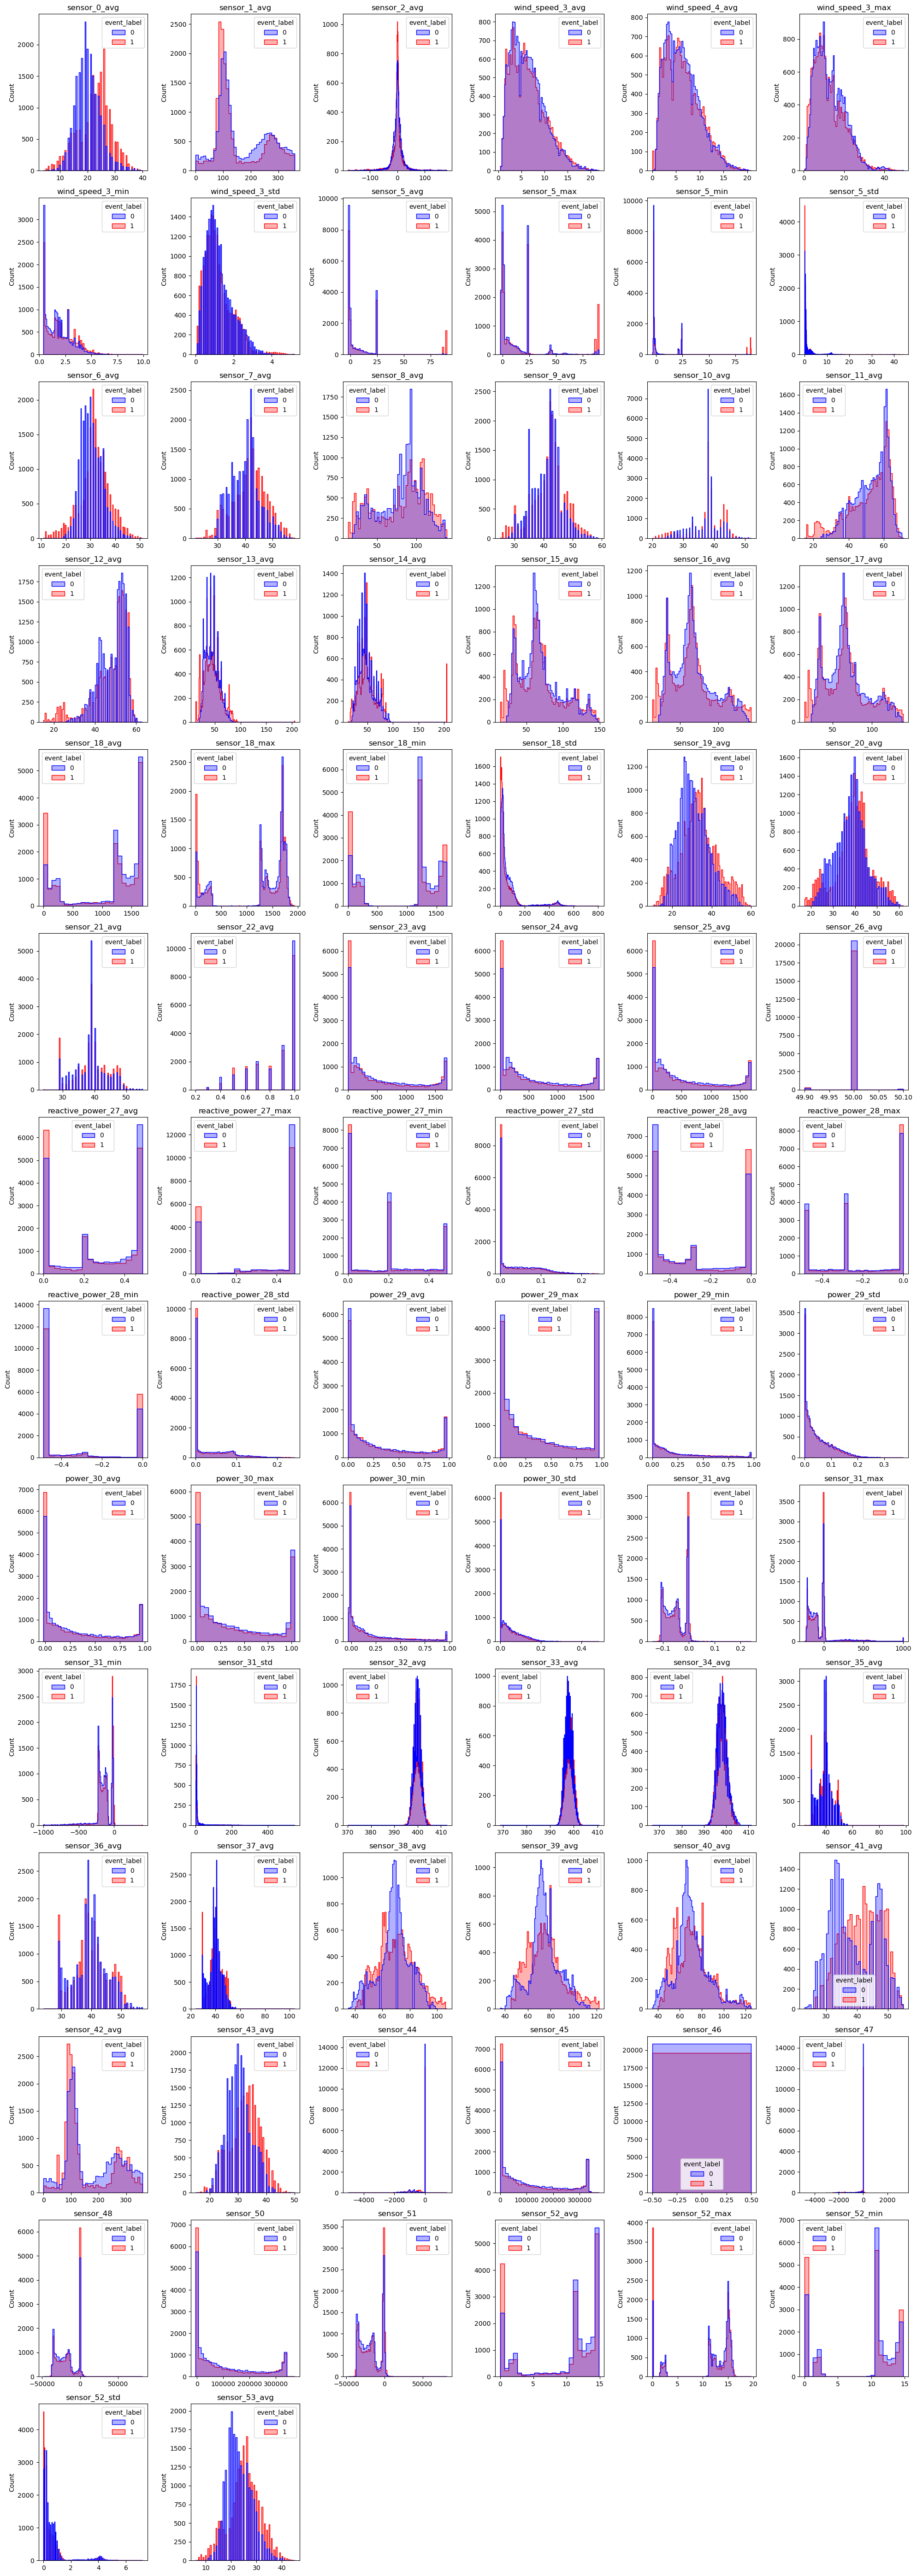

In [24]:
df_plot = X_train.copy()
df_plot['event_label'] = y_train.values

features = X_train.columns
n_features = len(features)
n_cols = 6
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(
        data=df_plot,
        x=col,
        hue='event_label',
        element="step",
        palette={0: "blue", 1: "red"},
        alpha=0.3,
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_xlabel("")

for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

HINT: here you can say: some feature is Discrete or binary, even show left-skewed 
Anyway it is not gaussian distribution
So we do Standardization (Z-score normalization) later to make them bell shape(normal distribution)
Interesting stuff: Bimodal Distribution


For Sensor 41 (oil temperature in the hydraulic group):
The left peak (low temperature region) represents the turbine being in idle or standby status, or operating at night / in winter. In this state, the hydraulic system is barely working, and the oil temperature stays close to ambient.
The right peak (high temperature region) corresponds to the turbine running at full load. The hydraulic system is active, so the oil temperature rises and stabilizes at a higher level.


/var/folders/q3/r_v4tt3n0hqb53bp2w2dg2hm0000gn/T/ipykernel_35837/2971615649.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/q3/r_v4tt3n0hqb53bp2w2dg2hm0000gn/T/ipykernel_35837/2971615649.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/q3/r_v4tt3n0hqb53bp2w2dg2hm0000gn/T/ipykernel_35837/2971615649.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/q3/r_v4tt3n0hqb53bp2w2dg2hm0000gn/T/ipykernel_35837/2971615649.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

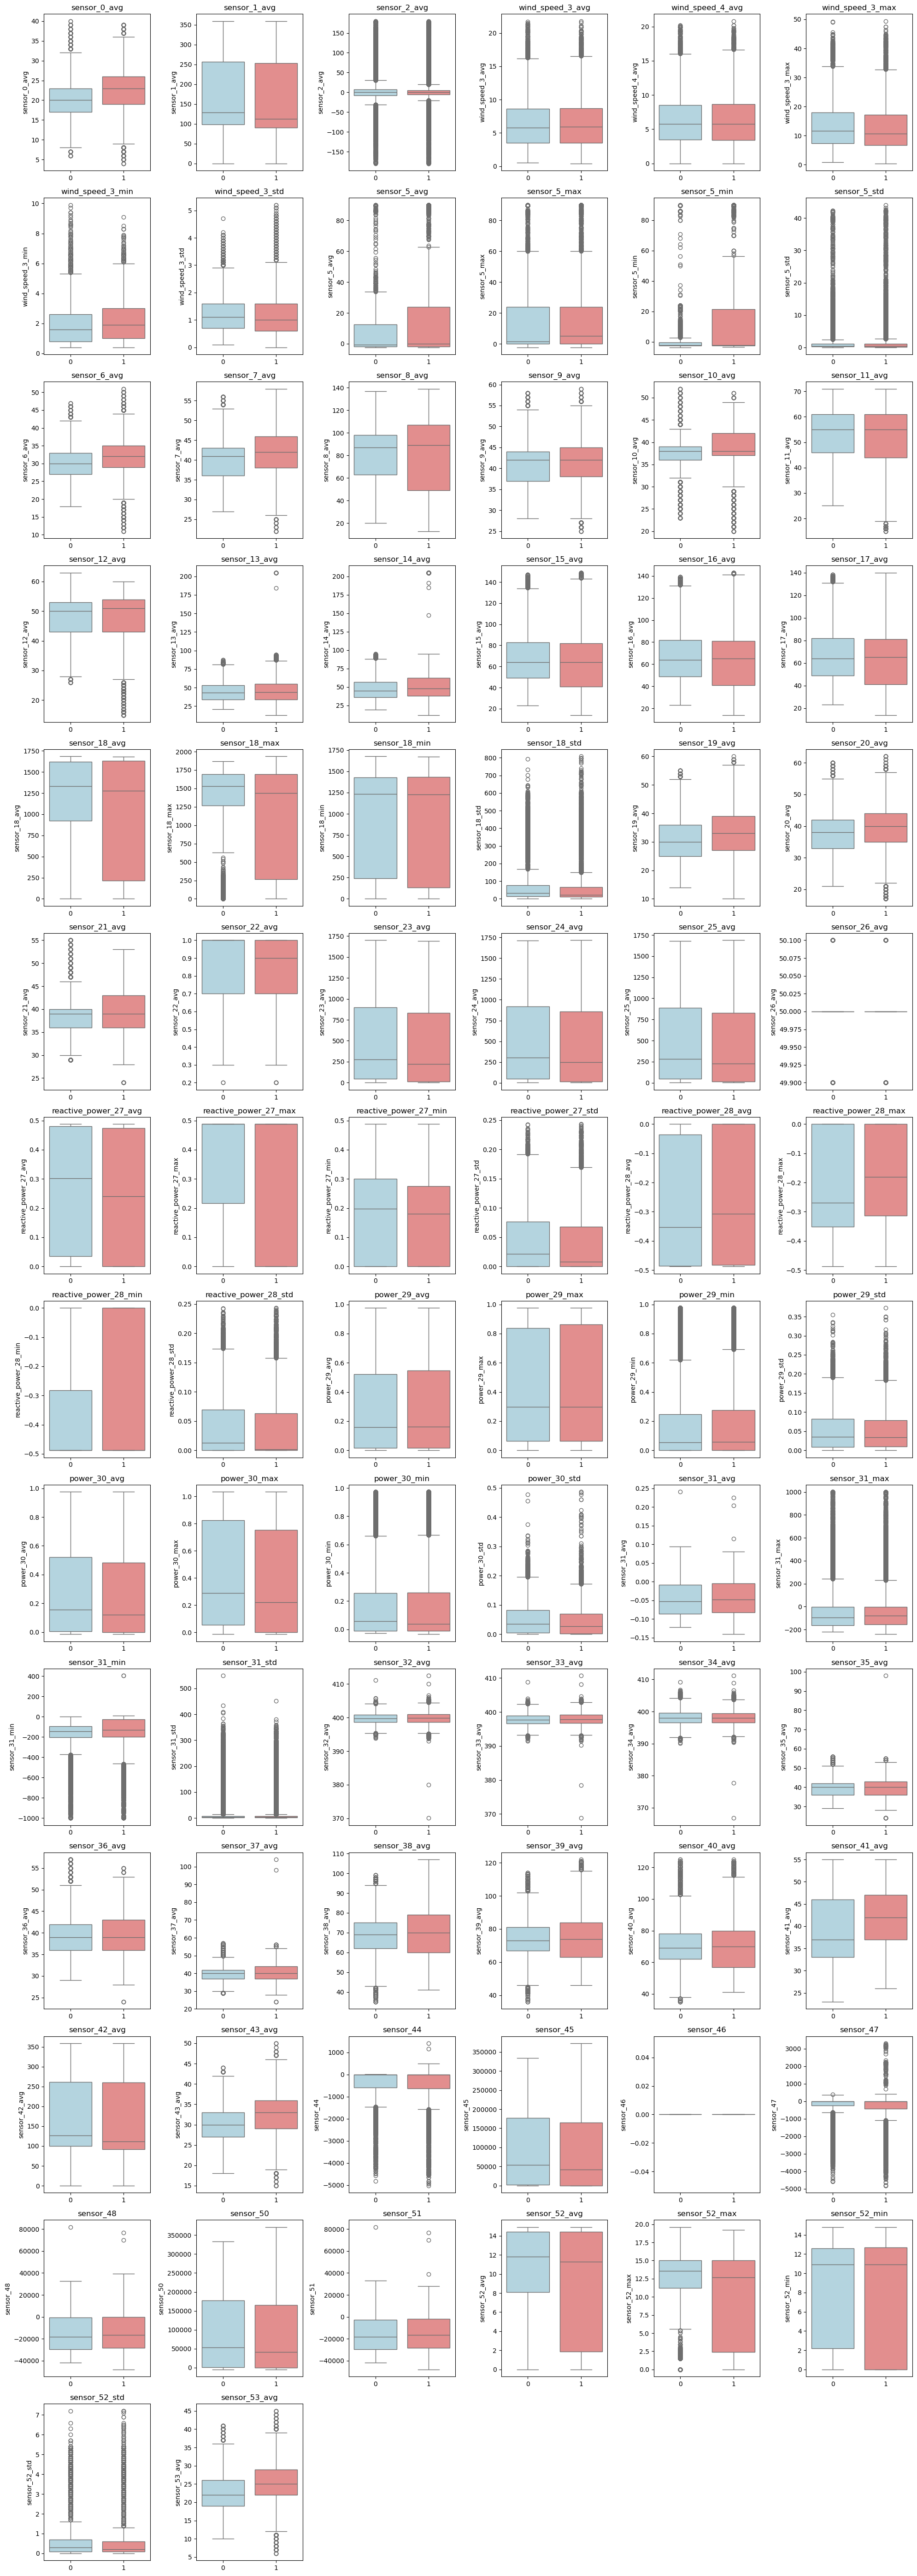

In [25]:
df_plot = X_train.copy()
df_plot['event_label'] = y_train.values.astype(int)

features = X_train.columns
n_features = len(features)
n_cols = 6 
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(
        data=df_plot,
        x='event_label',
        y=col,
        palette=['lightblue', 'lightcoral'],
        ax=axes[i]
    )
    
    axes[i].set_title(col)
    axes[i].set_xlabel("")

for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

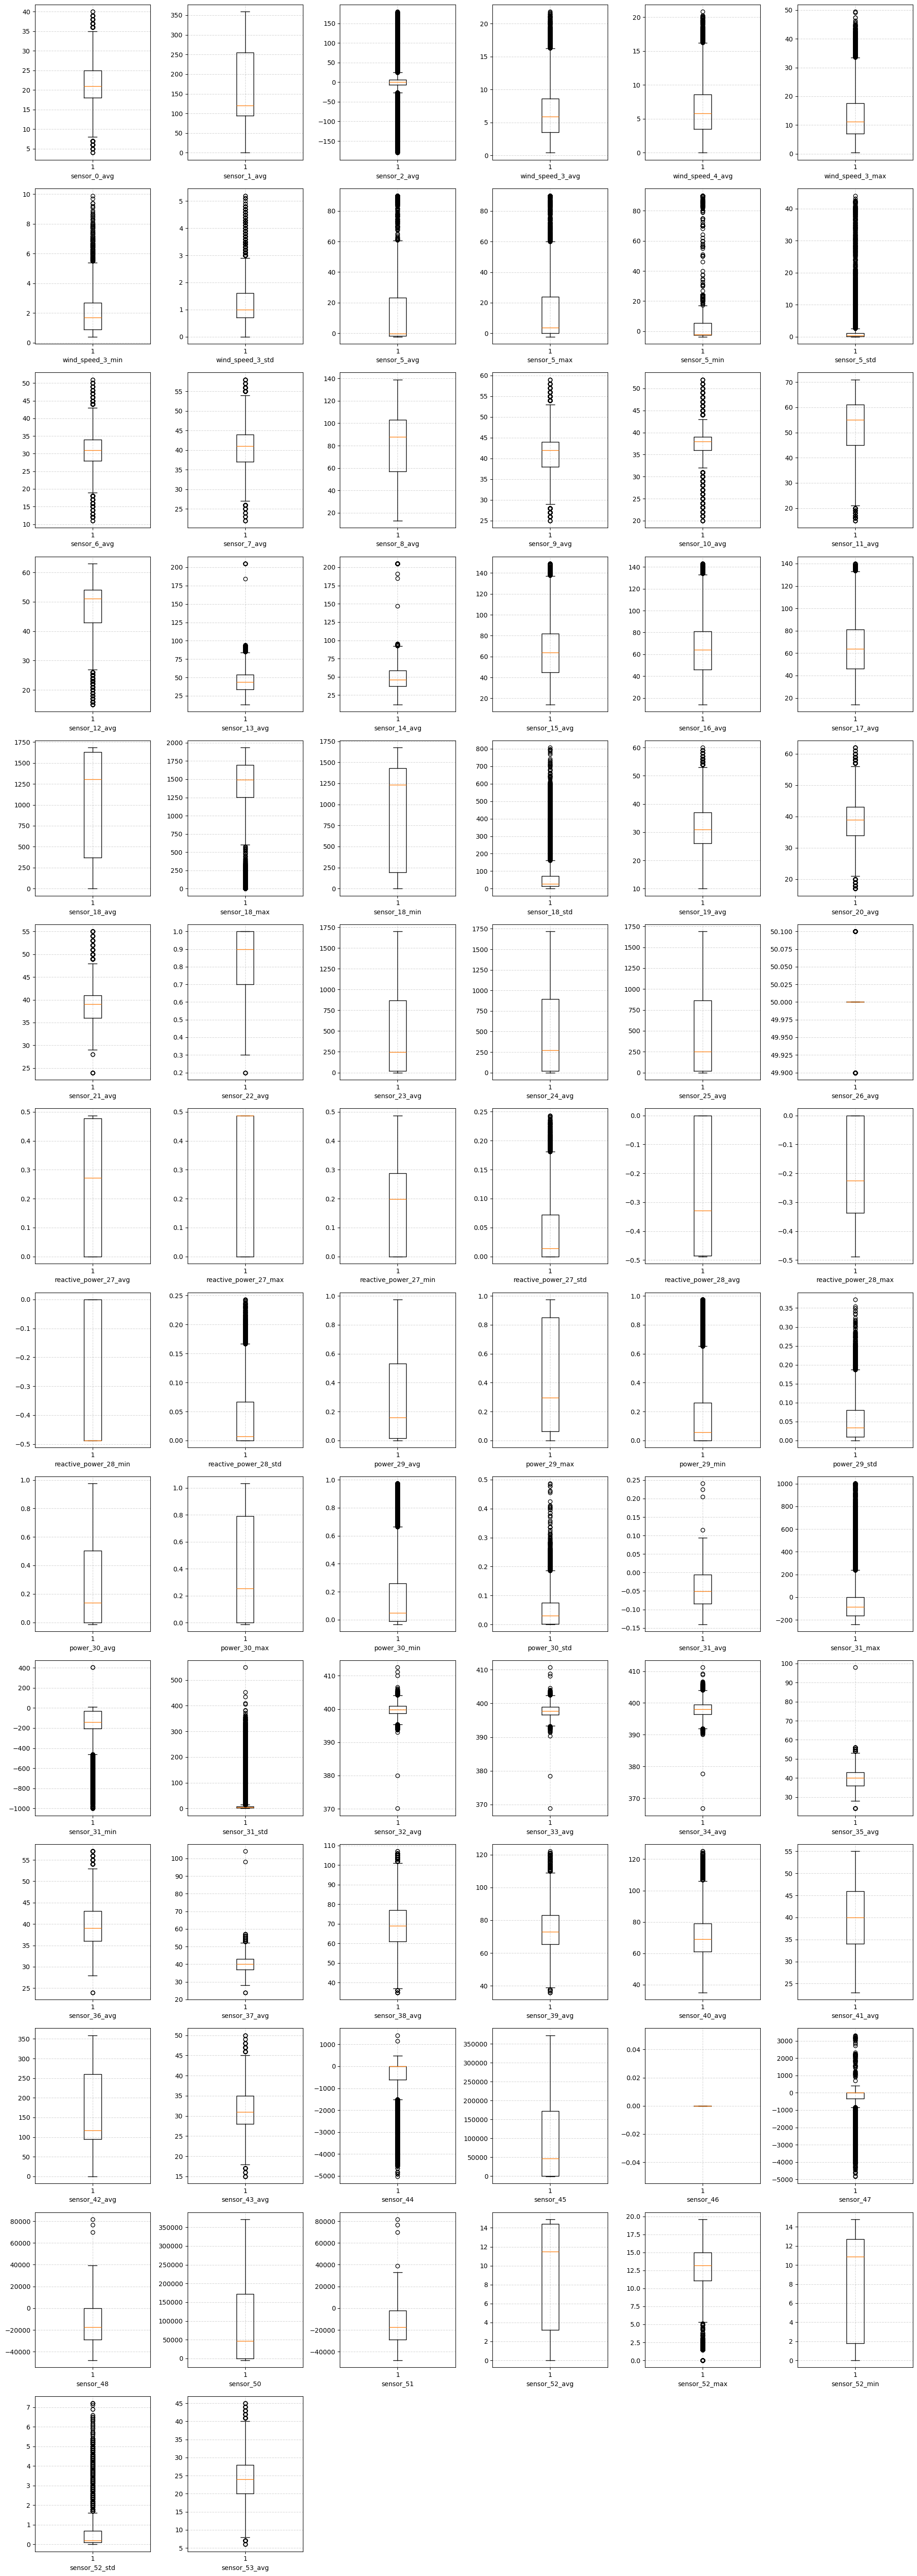

In [27]:
features = X_train.columns
n_features = len(features)
n_cols_per_row = 6
n_rows = math.ceil(n_features / n_cols_per_row)
plt.figure(figsize=(20, 4 * n_rows)) 

col = 1
for i in features:
    if col <= n_features:
        plt.subplot(n_rows, n_cols_per_row, col)
        plt.boxplot(X_train[i])
        plt.xlabel(i)
        plt.grid(True, linestyle='--', alpha=0.5)
        col = col + 1

plt.tight_layout()
plt.show()

From the boxplot we can discover some features have significant outliers, however, these outliers may represent real fault conditions rather than data errors. Therefore we decide to retain them for model training. If you compared boxplots between normal and fault samples, you may find that fault samples often exhibit more extreme values, which could be crucial for accurate fault detection.

## 3.2 Multivariate Analysis

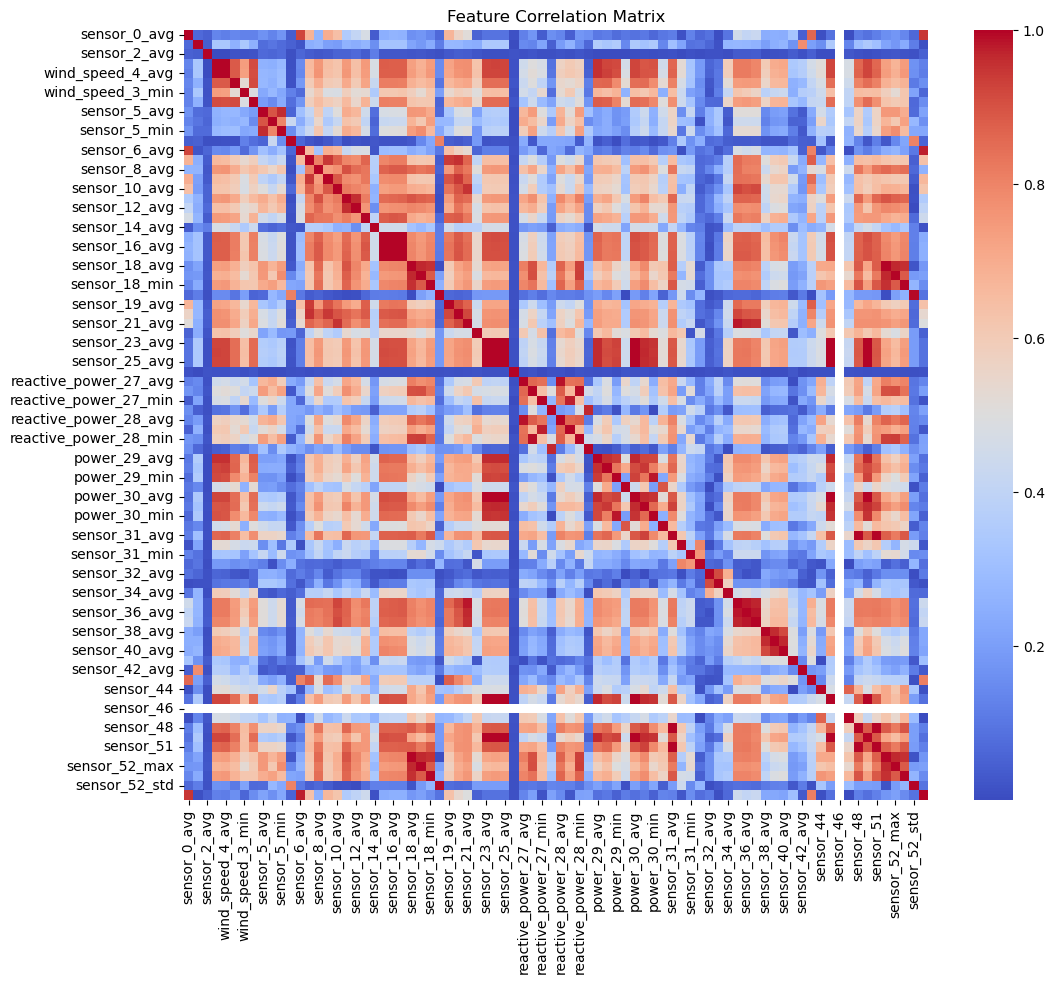

In [29]:
df_corr_calc = X_train.copy()

corr_matrix = df_corr_calc.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

We can see some features are highly correlated, we may consider dropping some of them to reduce redundancy and improve model performance. We will do that in 4. Feature Engineering.

In [30]:
# 用已经去掉 id、时间戳后的 df
df_corr_with_y = df_feature.copy()
df_corr_with_y['event_label'] = df_target.values

corr_with_label = df_corr_with_y.corr()['event_label'].drop('event_label')
corr_with_label = corr_with_label.sort_values(key=lambda x: x.abs(), ascending=False)

corr_with_label.head(20)


sensor_0_avg             0.232218
sensor_43_avg            0.229558
sensor_5_avg             0.204428
sensor_5_min             0.200354
sensor_41_avg            0.196595
sensor_5_max             0.180780
sensor_53_avg            0.179191
sensor_19_avg            0.162626
sensor_7_avg             0.143688
sensor_14_avg            0.137903
sensor_6_avg             0.119678
wind_speed_3_min         0.113232
sensor_52_max           -0.100975
sensor_18_max           -0.100570
sensor_18_avg           -0.094844
sensor_52_avg           -0.093545
sensor_42_avg           -0.087174
reactive_power_27_max   -0.086277
reactive_power_28_min    0.084710
sensor_18_min           -0.081374
Name: event_label, dtype: float64

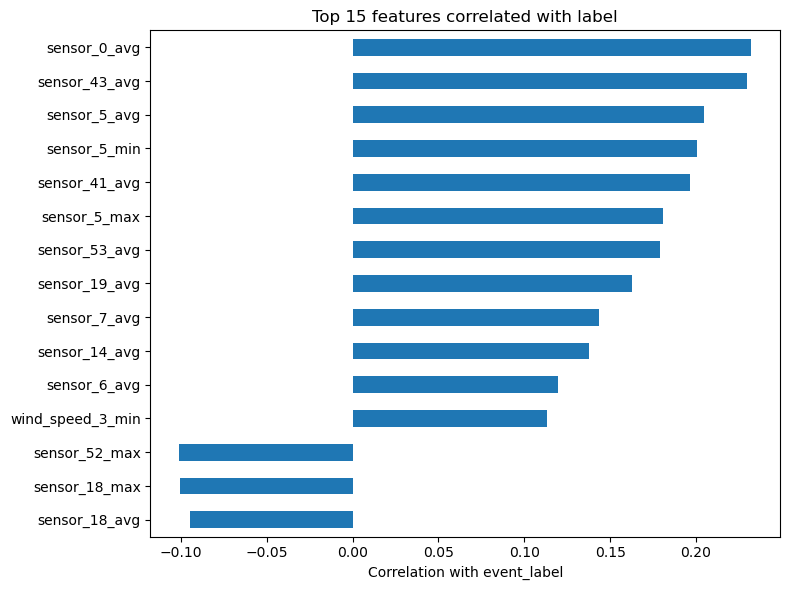

In [31]:
top_n = 15
plt.figure(figsize=(8, 6))
corr_with_label.head(top_n)[::-1].plot(kind='barh')
plt.xlabel("Correlation with event_label")
plt.title(f"Top {top_n} features correlated with label")
plt.tight_layout()
plt.show()


In order to intuitively understand which sensors are more closely related to fault labels, we calculated the correlation coefficient between each numerical feature and binary labels, and drew a bar chart of Top-15. The results show that some temperature/vibration-related sensors have obvious offsets in the fault samples, which provides intuitive support for subsequent feature selection (IV, LASSO, etc.).

# 4.	Feature Engineering

## 4.1 Quasi-Constant Feature Removal

### Removal of quasi-constant features, Low variance filter, Dominant category thresholding.

To reduce data dimensionality and noise, we applied a low-variance filter to remove quasi-constant features. Specifically, features were discarded if a single unique value occupied more than 90% of the samples, as these predictors offer limited discriminative power for the model.

In [32]:
threshold = 0.90
cols_to_drop = []

for col in X_train.columns:
    counts = X_train[col].value_counts(normalize=True)
        
    if len(counts) > 0 and counts.iloc[0] > threshold:
        cols_to_drop.append(col)

df_QC_cleaned = X_train.drop(columns=cols_to_drop)

print(f"original features number: {len(X_train.columns)}")
print("dropped features:", cols_to_drop)
print("remain features number:", df_QC_cleaned.shape[1])

original features number: 80
dropped features: ['sensor_26_avg', 'sensor_46']
remain features number: 78


## 4.2 Feature Selection based on Information Value / IV-based Feature Selection

To identify features with significant predictive power, we employed the Information Value (IV) selection method. Continuous features were first discretised into 10 bins using quantile binning. The Weight of Evidence (WoE) and IV were then calculated for each feature to quantify its ability to distinguish between normal and faulty states. Following standard industry practices, features with an IV less than or equal to 0.02 were considered 'useless' for prediction and were subsequently removed from the dataset.

Feature Selection using IV and WoE:We utilized the Information Value (IV) framework to reduce dimensionality. The procedure involved three steps:Discretization: Numeric features were binned into deciles (10 equal-frequency bins) to handle outliers and non-linearities.Calculation: For each bin $i$, the Weight of Evidence ($WoE_i$) was computed as the natural log of the ratio between the distribution of faulty samples and normal samples. The total IV for a feature was obtained by summing the weighted differences: $IV = \sum (Dist_{bad} - Dist_{good}) \times WoE$.Filtering: A threshold of $\tau = 0.02$ was applied. Features satisfying $IV \le 0.02$ were discarded due to weak predictive strength, resulting in a refined feature subset.

In [33]:
iv_df = df_QC_cleaned.copy()
target_col = 'target_temp' 
iv_df[target_col] = y_train.values
iv_list = []

for col in df_QC_cleaned:
    # binning
    iv_df['bin'] = pd.qcut(iv_df[col], q=10, duplicates='drop')
    
    # Good-Bad count
    grouped = iv_df.groupby('bin', observed=False)['target_temp'].agg(['count', 'sum'])
    # bad samples (anormaly, label=1)
    grouped['bad'] = grouped['sum']
    grouped['good'] = grouped['count'] - grouped['sum']
    
    # calculate portion
    dist_good = grouped['good'] / grouped['good'].sum()
    dist_bad = grouped['bad'] / grouped['bad'].sum()
    
    # WoE and IV calculation
    woe = np.log((dist_bad) / (dist_good))
    iv_value = ((dist_bad - dist_good) * woe).sum()
    
    iv_list.append({'Feature': col, 'IV': iv_value})

# result
df_iv_result = pd.DataFrame(iv_list).sort_values(by='IV', ascending=False)

# Print Top 10 strongest features
print("Top 10 strongest features:")
print(df_iv_result.head(10))

# 4. Threshold > 0.02
iv_threshold = 0.02
selected_features = df_iv_result[df_iv_result['IV'] > iv_threshold]['Feature'].tolist()
dropped_features = df_iv_result[df_iv_result['IV'] <= iv_threshold]['Feature'].tolist()

df_IV_cleaned = df_QC_cleaned[selected_features]

print(f"before selecting, features number: {df_QC_cleaned.shape[1]}")
print(f"dropped features number: {len(dropped_features)} (IV <= {iv_threshold})")
print(f"remaining features number: {len(selected_features)}")

Top 10 strongest features:
          Feature        IV
0    sensor_0_avg  0.624339
77  sensor_53_avg  0.387556
66  sensor_43_avg  0.385827
64  sensor_41_avg  0.359506
12   sensor_6_avg  0.319111
10   sensor_5_min  0.309498
8    sensor_5_avg  0.243719
62  sensor_39_avg  0.221555
61  sensor_38_avg  0.198462
28  sensor_19_avg  0.187023
before selecting, features number: 78
dropped features number: 16 (IV <= 0.02)
remaining features number: 62


## 4.3 Correlation-Based Multicollinearity Reduction

Multicollinearity Reduction: To mitigate the risk of multicollinearity while preserving predictive power, we implemented a greedy selection strategy based on Information Value (IV).

1. Ranking: All candidate features were ranked in descending order based on their IV scores.

2. Filtering: Starting with the highest-ranked feature (the 'leader'), we calculated the pairwise Pearson correlation coefficients with all subsequent features.

3. Selection: Any feature exhibiting a correlation absolute value greater than 0.6 with the leader was identified as redundant and removed, as the leader possesses superior discriminative power. This iterative process was repeated for the remaining features until the entire set was traversed, resulting in a subset of uncorrelated features with high predictive value.

In [34]:
corr_data = df_IV_cleaned.copy()
corr_matrix = corr_data.corr().abs()
sorted_features = selected_features.copy()
iv_mapping = df_iv_result.set_index('Feature')['IV'].to_dict()

group = []
group_list = []
group_count = 0

for leader in sorted_features:
    if leader in group:
        continue
    
    group_count += 1
    group.append(leader)
    leader_iv = iv_mapping.get(leader, 0)
    group_list.append({
        'Group_id': group_count,
        'Feature': leader,
        'Correlation': 1,
        'IV': leader_iv
        })
    
    print(f"Group {group_count} highest IV: {leader}, IV: {leader_iv:.4f}")
    
    for member in sorted_features:
        if member in group:
            continue

        score = corr_matrix.loc[leader, member]
        if score > 0.6:
            print(f"    strong correlation member: {member} (correlation coefficient: {score:.2f}, IV: {iv_mapping.get(member, 0):.4f})")
            group.append(member)
            member_iv = iv_mapping.get(member, 0)
            group_list.append({
            'Group_id': group_count,
            'Feature': member,
            'Correlation': score,
            'IV': member_iv
            })


Group 1 highest IV: sensor_0_avg, IV: 0.6243
    strong correlation member: sensor_53_avg (correlation coefficient: 0.95, IV: 0.3876)
    strong correlation member: sensor_43_avg (correlation coefficient: 0.86, IV: 0.3858)
    strong correlation member: sensor_6_avg (correlation coefficient: 0.92, IV: 0.3191)
    strong correlation member: sensor_19_avg (correlation coefficient: 0.68, IV: 0.1870)
    strong correlation member: sensor_7_avg (correlation coefficient: 0.68, IV: 0.1709)
    strong correlation member: sensor_10_avg (correlation coefficient: 0.64, IV: 0.1476)
    strong correlation member: sensor_9_avg (correlation coefficient: 0.70, IV: 0.1045)
Group 2 highest IV: sensor_41_avg, IV: 0.3595
Group 3 highest IV: sensor_5_min, IV: 0.3095
    strong correlation member: sensor_5_avg (correlation coefficient: 0.96, IV: 0.2437)
    strong correlation member: sensor_8_avg (correlation coefficient: 0.62, IV: 0.1501)
    strong correlation member: sensor_18_avg (correlation coefficien

In [35]:
pd.DataFrame(group_list)

Group_id                Feature  Correlation        IV
0          1           sensor_0_avg     1.000000  0.624339
1          1          sensor_53_avg     0.949101  0.387556
2          1          sensor_43_avg     0.863273  0.385827
3          1           sensor_6_avg     0.924075  0.319111
4          1          sensor_19_avg     0.675597  0.187023
..       ...                    ...          ...       ...
57        10       wind_speed_3_min     1.000000  0.055827
58        11          sensor_31_min     1.000000  0.055303
59        11          sensor_31_std     0.755302  0.035835
60        12  reactive_power_27_std     1.000000  0.027880
61        13          sensor_31_max     1.000000  0.023701

[62 rows x 4 columns]

Here is introduce that, for example, `sensor_0_avg` is what and `sensor_53_avg` is what, they have high correlation score which will cause linearity issue in logistic regression model. So we only keep `sensor_0_avg` since it has higher IV score.

In [36]:
df_group_list = pd.DataFrame(group_list)
decided_features = df_group_list[df_group_list['Correlation'] == 1].reset_index(drop=True)
decided_features

Group_id                Feature  Correlation        IV
0          1           sensor_0_avg          1.0  0.624339
1          2          sensor_41_avg          1.0  0.359506
2          3           sensor_5_min          1.0  0.309498
3          4          sensor_39_avg          1.0  0.221555
4          5          sensor_42_avg          1.0  0.147032
5          6          sensor_14_avg          1.0  0.107553
6          7           sensor_2_avg          1.0  0.081706
7          8          sensor_18_std          1.0  0.072249
8          9           power_30_std          1.0  0.060456
9         10       wind_speed_3_min          1.0  0.055827
10        11          sensor_31_min          1.0  0.055303
11        12  reactive_power_27_std          1.0  0.027880
12        13          sensor_31_max          1.0  0.023701

In [37]:
df_Corr_cleaned = df_IV_cleaned[decided_features['Feature'].tolist()]
df_Corr_cleaned

sensor_0_avg  sensor_41_avg  sensor_5_min  sensor_39_avg  \
52526            28.0           39.0          -2.3           80.0   
544569           21.0           39.0          -2.7           69.0   
1196712          17.0           31.0          -2.3           72.0   
761900           23.0           39.0          -2.2           75.0   
218049           35.0           47.0          -1.7           78.0   
...               ...            ...           ...            ...   
1196211          11.0           28.0          24.0           71.0   
814655           20.0           46.0          -2.5           70.0   
108474           12.0           44.0          -2.1           68.0   
272125           24.0           50.0          -3.0           67.0   
815147           16.0           48.0          23.9           67.0   

         sensor_42_avg  sensor_14_avg  sensor_2_avg  sensor_18_std  \
52526            304.7           49.0          -0.4           87.6   
544569           106.3           64.0          -2.4           77.4   
1196712          347.0           41.0         -24.4          477.7   
761900           290.3           40.0          -0.8           16.5   
218049            26.5           48.0          -1.3          229.9   
...                ...            ...           ...            ...   
1196211          309.1           32.0         -69.8           11.0   
814655           128.8           49.0           1.9           31.3   
108474           331.1           39.0          -9.8           11.0   
272125           267.1           46.0          33.7          107.1   
815147           343.7           26.0         -23.3           20.3   

         power_30_std  wind_speed_3_min  sensor_31_min  reactive_power_27_std  \
52526        0.058341               1.7         -136.1               0.010439   
544569       0.036634               2.0         -172.0               0.000000   
1196712      0.034927               0.6         -573.8               0.160683   
761900       0.052341               1.3         -108.1               0.170049   
218049       0.032829               0.8         -514.3               0.138293   
...               ...               ...            ...                    ...   
1196211      0.001268               0.8          -23.2               0.000000   
814655       0.116732               3.0         -201.1               0.049366   
108474       0.018244               1.7         -117.5               0.077659   
272125       0.090683               1.1         -113.4               0.080341   
815147       0.001415               0.4          -14.9               0.000000   

         sensor_31_max  
52526           -114.8  
544569          -147.3  
1196712          918.4  
761900             0.3  
218049           424.8  
...                ...  
1196211           -8.0  
814655          -185.4  
108474           -90.6  
272125           -94.4  
815147           -11.5  

[40474 rows x 13 columns]

## 4.4 VIF check

Multicollinearity Check using VIF:
While pairwise correlation analysis removes highly correlated pairs, it fails to detect multicollinearity arising from linear combinations of multiple predictors. To address this, we employed the Variance Inflation Factor (VIF) analysis as a final filter. The VIF for a feature $X_i$ is calculated as $VIF_i = \frac{1}{1 - R_i^2}$, where $R_i^2$ is the coefficient of determination obtained by regressing $X_i$ on all other remaining features.


In [38]:
vif_df = df_Corr_cleaned.copy()
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns
vif_data["VIF"] = [VIF(vif_df.values, i) for i in range(vif_df.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))

                  feature        VIF
3           sensor_39_avg  42.447796
1           sensor_41_avg  40.257701
0            sensor_0_avg  18.151374
5           sensor_14_avg   7.721936
9        wind_speed_3_min   5.822714
10          sensor_31_min   5.443067
4           sensor_42_avg   4.153046
8            power_30_std   3.471400
12          sensor_31_max   3.417115
11  reactive_power_27_std   2.689227
7           sensor_18_std   2.095120
2            sensor_5_min   2.018656
6            sensor_2_avg   1.022370


In [39]:
vif_df = vif_df.drop(columns=['sensor_39_avg'])
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns
vif_data["VIF"] = [VIF(vif_df.values, i) for i in range(vif_df.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))

                  feature        VIF
1           sensor_41_avg  24.721065
0            sensor_0_avg  17.248115
4           sensor_14_avg   7.320729
8        wind_speed_3_min   5.753734
9           sensor_31_min   5.242778
3           sensor_42_avg   4.079111
7            power_30_std   3.457479
11          sensor_31_max   3.293276
10  reactive_power_27_std   2.684753
6           sensor_18_std   2.091593
2            sensor_5_min   2.015077
5            sensor_2_avg   1.022358


In [40]:
vif_df = vif_df.drop(columns=['sensor_41_avg'])
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns
vif_data["VIF"] = [VIF(vif_df.values, i) for i in range(vif_df.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))

                  feature       VIF
0            sensor_0_avg  9.708498
3           sensor_14_avg  7.033550
7        wind_speed_3_min  5.499953
8           sensor_31_min  5.090631
2           sensor_42_avg  3.647745
6            power_30_std  3.449943
10          sensor_31_max  3.179594
9   reactive_power_27_std  2.660406
5           sensor_18_std  2.034245
1            sensor_5_min  1.910877
4            sensor_2_avg  1.021117


Initially, sensor_39_avg and sensor_41_avg exhibited severe multicollinearity with VIF values exceeding 40. We proceeded step-by-step:
First, we removed sensor_39_avg (highest VIF). Re-evaluation showed sensor_41_avg still had a VIF of 24.7.
Consequently, we removed sensor_41_avg.
After this procedure, all remaining features possessed VIF values below the threshold of 10 (or 5, depending on your final result), ensuring the independence of the predictors. Finally, Lasso regression was performed on this refined feature set.

We employed Lasso (Least Absolute Shrinkage and Selection Operator) regression as an embedded feature selection method. Lasso addresses multicollinearity by imposing an L1 regularization penalty on the regression coefficients, effectively shrinking the coefficients of redundant or irrelevant features to exactly zero. This data-driven approach allows the model to handle high-dimensional and collinear data by selecting the most predictive subset of features during the training process, thereby preserving informative variables that might otherwise be removed by manual filtering

## 4.5 standardization

It is important to note that, as Lasso regularization is sensitive to the scale of input variables, all numerical features were standardized (Z-score scaling) prior to the regression analysis.

In [41]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(vif_df), index=vif_df.index, columns=vif_df.columns)
df_scaled.shape

(40474, 11)

In [42]:
df_scaled.var()

sensor_0_avg             1.000025
sensor_5_min             1.000025
sensor_42_avg            1.000025
sensor_14_avg            1.000025
sensor_2_avg             1.000025
sensor_18_std            1.000025
power_30_std             1.000025
wind_speed_3_min         1.000025
sensor_31_min            1.000025
reactive_power_27_std    1.000025
sensor_31_max            1.000025
dtype: float64

## 4.6 LASSO Feature Selection

LassoCV intro

In [43]:
lasso_cv = LassoCV(cv=10, random_state=1) 
lasso_cv.fit(df_scaled, y_train)

LassoCV(cv=10, random_state=1)

In [44]:
coef_series = pd.DataFrame(lasso_cv.coef_, index=df_scaled.columns)
coef_series_sorted_abs = coef_series.sort_values(by=0, key=abs, ascending=False)
coef_series_sorted_abs

0
sensor_0_avg           0.127960
sensor_5_min           0.117860
wind_speed_3_min       0.071828
sensor_14_avg          0.043089
sensor_31_max          0.036649
sensor_31_min          0.027467
sensor_42_avg         -0.015444
power_30_std          -0.012994
sensor_18_std          0.012276
reactive_power_27_std  0.004839
sensor_2_avg          -0.000281

**Noise Removal**: Features with negligible coefficients (e.g., sensor_2_avg, |coef| < 0.001) were pruned to enhance model simplicity without sacrificing accuracy.

In [45]:
final_selected_features = coef_series_sorted_abs[0].index.tolist()
final_selected_features

['sensor_0_avg',
 'sensor_5_min',
 'wind_speed_3_min',
 'sensor_14_avg',
 'sensor_31_max',
 'sensor_31_min',
 'sensor_42_avg',
 'power_30_std',
 'sensor_18_std',
 'reactive_power_27_std',
 'sensor_2_avg']

## 4.7 Final Feature Set 1

The remaining 10 features constitute the optimal subset. We then projected both the training and testing datasets onto this reduced feature space to ensure that the final predictive model focuses solely on the most impactful predictors.

To maintain consistency and prevent data leakage, this specific subset of columns was extracted from both the training set (X_train) and the testing set (X_test). These filtered datasets serve as the input for the subsequent model training and evaluation phases.

In [46]:
X_train_finalset1 = X_train[final_selected_features].copy()
X_test_finalset1 = X_test[final_selected_features].copy()

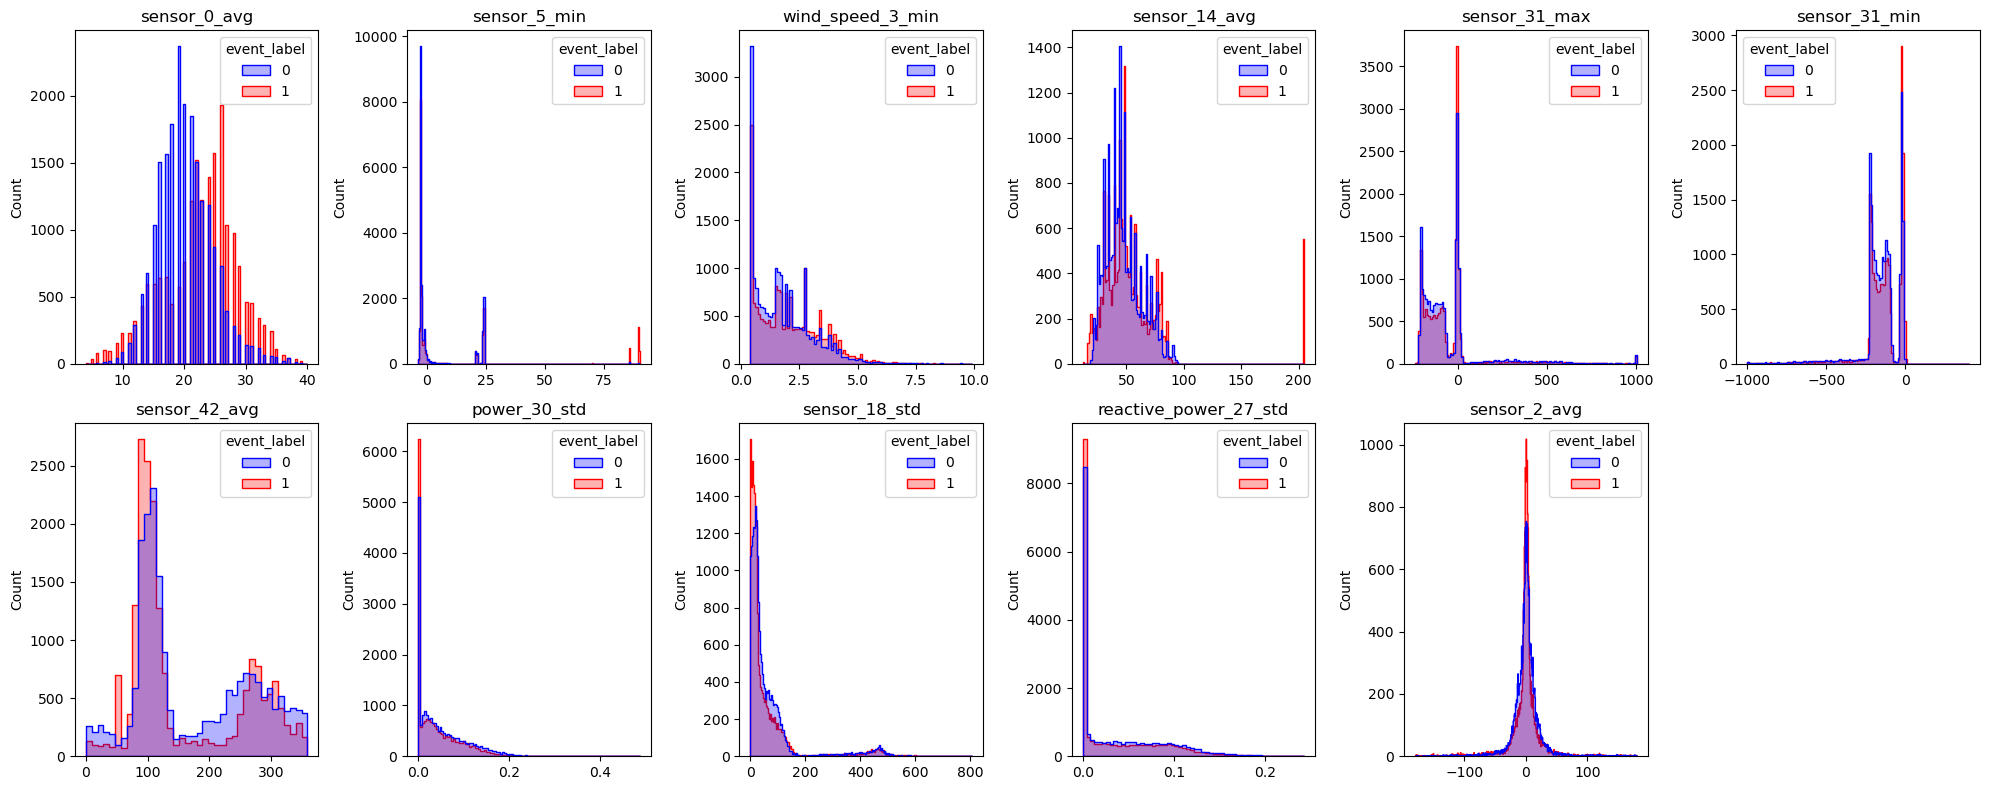

In [47]:
df_plot = X_train_finalset1.copy()
df_plot['event_label'] = y_train.values

features = X_train_finalset1.columns
n_features = len(features)
n_cols = 6
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(
        data=df_plot,
        x=col,
        hue='event_label',
        element="step",
        palette={0: "blue", 1: "red"},
        alpha=0.3,
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_xlabel("")

for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

distribution plot after feature engineering shows that the features are more normally distributed, which is beneficial for models like logistic regression that assume normality.

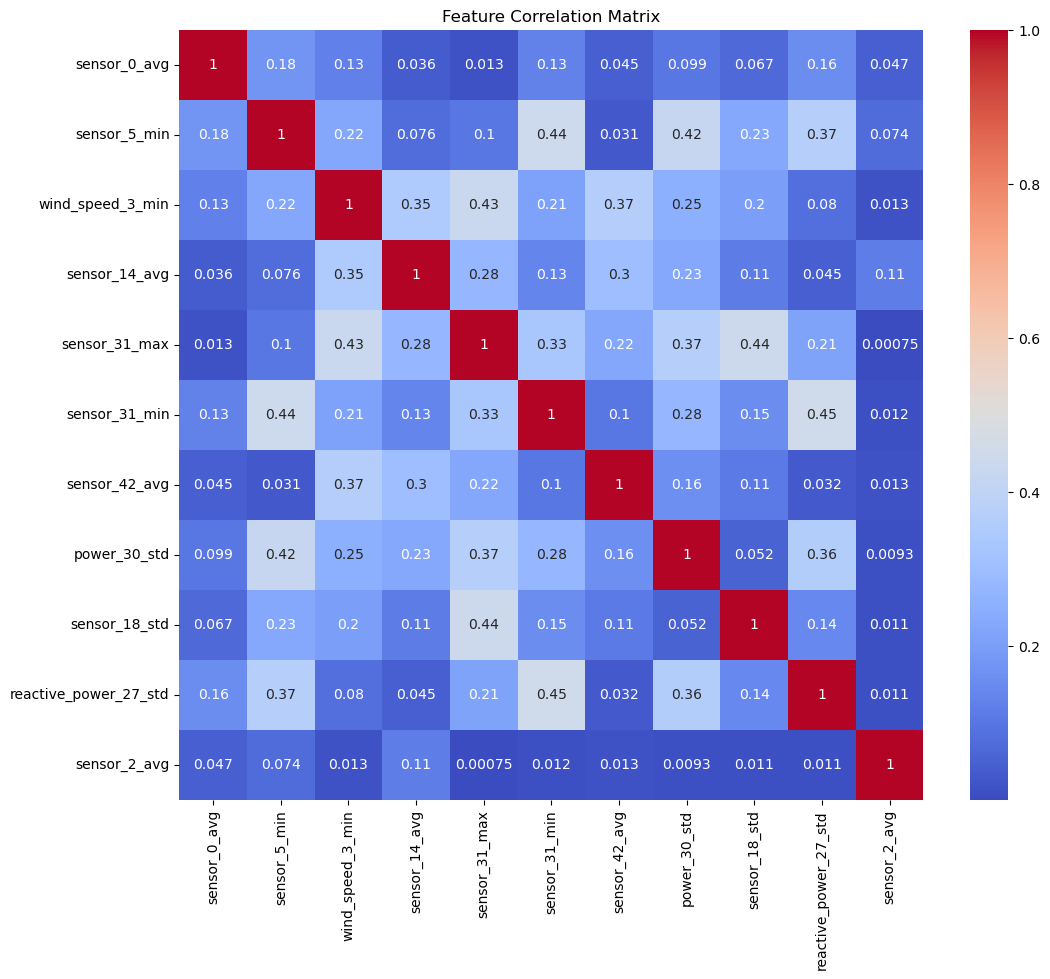

In [48]:
df_corr_calc = X_train_finalset1.copy()

corr_matrix = df_corr_calc.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Feature Correlation Matrix")
plt.show()

low correlation heatmap for final feature set 1 shows that after feature engineering, the multicollinearity issue has been effectively addressed, with all pairwise correlations below the 0.6 threshold.

## 4.8 unsupervised Feature Selection PCA

### 4.8.1 PCA Component Selection and Variance Analysis

We use PCA to reduce dimensionality as well as feature selection.
To evaluate the effectiveness of our supervised feature selection pipeline (Section 4.7), we implemented Principal Component Analysis (PCA) as an unsupervised alternative strategy for dimensionality reduction.

Unlike the Lasso-based approach, which selects a subset of interpretable original features, PCA transforms the entire feature space into a new set of orthogonal (uncorrelated) components. We applied PCA to the comprehensive standardized dataset (prior to the quasi-constant and IV-based filtering steps) to capture the global data structure without manual pre-filtering constraints.

This approach serves as a comparative baseline. In the subsequent modeling phase, we will assess whether the interpretable subset selected by Lasso (Feature Set 1) outperforms the information-rich but less interpretable components generated by PCA (Feature Set 2).

In [49]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_train.values), index=X_train.index, columns=X_train.columns)
X.shape

(40474, 80)

In [50]:
pca_X = PCA()

In [51]:
pc_scores = pd.DataFrame(pca_X.fit_transform(X), index=X.index)
pc_scores.head(3)

0         1         2         3         4         5         6   \
52526    1.959241 -1.844983  0.819550 -2.050943  1.596265  1.871354  0.975499   
544569   2.415523 -2.307351 -1.846069 -1.499688  1.213086 -1.387121 -0.042299   
1196712 -5.073096 -4.599482  4.230984  7.949101 -0.407475 -1.172130 -0.634178   

               7         8         9   ...        70        71        72  \
52526    1.014530  1.964571  0.381086  ... -0.009574  0.002719  0.004535   
544569  -1.133512  0.192319  0.113402  ... -0.005874  0.001269 -0.009966   
1196712 -0.240905  2.417895  1.960625  ...  0.007168 -0.030656  0.008796   

               73        74        75        76            77            78  \
52526   -0.003547 -0.003870 -0.005167 -0.000649  7.364660e-07 -5.709752e-10   
544569  -0.000588  0.007854  0.002861  0.000522 -1.177364e-07  4.148422e-09   
1196712 -0.032069  0.007963 -0.000158 -0.008437 -5.331848e-05 -1.209483e-07   

                   79  
52526    1.594038e-16  
544569   2.049895e-16  
1196712  2.091832e-14  

[3 rows x 80 columns]

In [52]:
pc_scores.var()

0     4.107201e+01
1     7.581802e+00
2     6.398710e+00
3     3.825566e+00
4     2.551311e+00
          ...     
75    2.387508e-05
76    1.094099e-05
77    6.796753e-11
78    9.186393e-13
79    2.411135e-29
Length: 80, dtype: float64

We use eigenvalue decomposition to compute the principal components. The eigenvalues indicate the amount of variance captured by each principal component, while the eigenvectors define the directions of these components in the feature space.

In [53]:
var_series = pc_scores.var(axis=0)
selected_pc_scores = pc_scores.loc[:, var_series > 1]
selected_pc_scores.var()

0     41.072009
1      7.581802
2      6.398710
3      3.825566
4      2.551311
5      2.081698
6      1.974368
7      1.693801
8      1.362002
9      1.146394
10     1.085352
11     1.001567
dtype: float64

We are supposed to use 12 principal components

### 4.8.2 Visual Analysis of the Feature Space

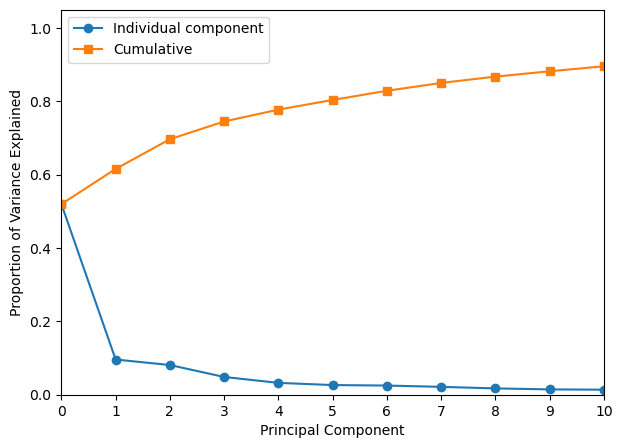

In [54]:
plt.figure(figsize=(7,5))
plt.plot(pca_X.explained_variance_ratio_, '-o', label='Individual component')
plt.plot( np.cumsum(pca_X.explained_variance_ratio_), '-s', label='Cumulative')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.legend(loc=2)

In [55]:
pca = PCA().fit(X)
print(pca_X.explained_variance_ratio_)
print(len(pca.explained_variance_ratio_[:12]))
sum(pca.explained_variance_ratio_[:12])

[5.19886004e-01 9.59698121e-02 8.09943249e-02 4.84236958e-02
 3.22942772e-02 2.63499563e-02 2.49913821e-02 2.14399836e-02
 1.72401076e-02 1.45109559e-02 1.37382985e-02 1.26777542e-02
 1.21754979e-02 1.01028556e-02 9.42082492e-03 7.71773447e-03
 5.80718685e-03 5.12513983e-03 4.49986399e-03 3.98439203e-03
 3.28912446e-03 2.66165170e-03 2.55685102e-03 2.16258231e-03
 2.12141764e-03 1.79624764e-03 1.64150851e-03 1.48655906e-03
 1.22924372e-03 1.17873700e-03 1.14621939e-03 1.09997295e-03
 1.03775835e-03 8.82852789e-04 8.26538092e-04 7.52943204e-04
 7.01060032e-04 6.34675865e-04 5.23051012e-04 4.61741020e-04
 4.49233710e-04 4.25636294e-04 3.85987423e-04 3.64900586e-04
 3.00848232e-04 2.71366380e-04 2.42662709e-04 2.22823968e-04
 1.97801619e-04 1.83385882e-04 1.64881921e-04 1.50510506e-04
 1.49108142e-04 1.43284565e-04 1.27813308e-04 1.11765902e-04
 9.00117312e-05 8.42964967e-05 7.95690892e-05 6.83385773e-05
 6.12357952e-05 4.71858306e-05 3.42307028e-05 2.93148398e-05
 1.68428261e-05 1.409330

np.float64(0.9085165522607068)

We are ising 12 principal components, which together explain approximately 90.85% of the total variance in the dataset. This selection balances dimensionality reduction with information retention, providing a compact yet informative feature set for subsequent modeling tasks.

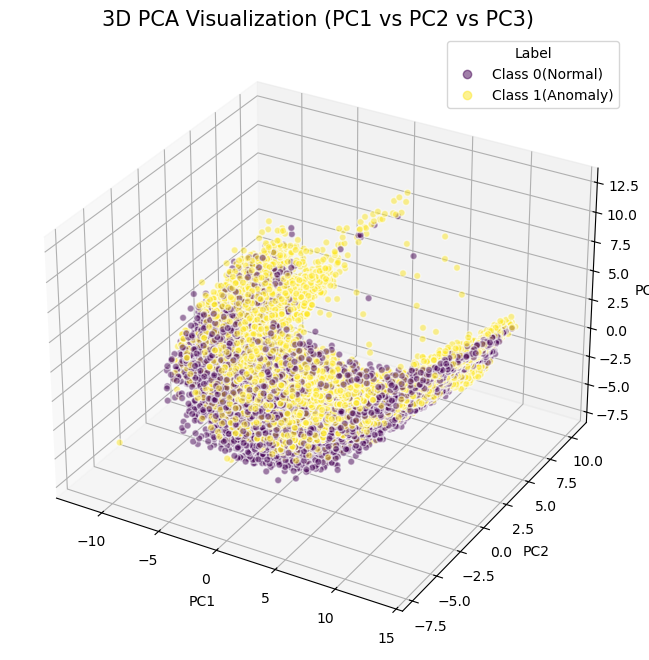

In [56]:
color_labels = y_train
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = pc_scores.iloc[:, 0]
y = pc_scores.iloc[:, 1]
z = pc_scores.iloc[:, 2]

scatter = ax.scatter(x, y, z, 
                     c=color_labels,
                     cmap='viridis',
                     s=25,
                     alpha=0.5,
                     edgecolors='w')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Visualization (PC1 vs PC2 vs PC3)', fontsize=15)

handles, _ = scatter.legend_elements(prop="colors")
legend = ax.legend(handles, ['Class 0(Normal)', 'Class 1(Anomaly)'], 
                   title="Label", 
                   loc="upper right")

plt.show()

To inspect the global structure of the data, we visualized the first three principal components (PC1, PC2, and PC3) in a 3D scatter plot.
The visualization reveals that the data does not form distinct, isolated clusters but rather spans a continuous, non-linear manifold structure. PC1 (X-axis) clearly captures the primary direction of data spread.

### 4.8.3 PCA feature set

In [57]:
scaler = StandardScaler()
# fit for train
X_train_scaled = scaler.fit_transform(X_train)
# transform for test
X_test_scaled = scaler.transform(X_test)

In [58]:
n_components = 12
pca = PCA(n_components=n_components)

In [59]:
# fit for train
X_train_pca_array = pca.fit_transform(X_train_scaled)
# transform for test
X_test_pca_array = pca.transform(X_test_scaled)

In [60]:
pc_columns = [f'PC{i+1}' for i in range(n_components)]

In [61]:
X_train_final_pca = pd.DataFrame(X_train_pca_array, columns=pc_columns, index=X_train.index)
X_test_final_pca = pd.DataFrame(X_test_pca_array, columns=pc_columns, index=X_test.index)
X_train_final_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
52526    1.959241 -1.844983  0.819550 -2.050943  1.596265  1.871354  0.975499   
544569   2.415523 -2.307351 -1.846069 -1.499688  1.213086 -1.387121 -0.042299   
1196712 -5.073096 -4.599482  4.230984  7.949101 -0.407475 -1.172130 -0.634178   
761900  -1.472215 -2.757431  1.566224  0.678119 -2.716222  2.665685  0.270667   
218049  -1.167439 -1.719579  8.490628  2.570357 -0.080752  1.866181  0.668809   

              PC8       PC9      PC10      PC11      PC12  
52526    1.014530  1.964571  0.381086  0.064222  0.004690  
544569  -1.133512  0.192319  0.113402 -0.521858  0.049811  
1196712 -0.240905  2.417895  1.960625  0.246750  0.456827  
761900   1.740627 -0.023843 -0.839516 -1.209472 -0.432558  
218049  -3.685129 -0.885350  0.356345 -0.091643  0.113179

# 5.   Model Training & Evaluation

Then we will use these two feature sets to train our models and compare their performance.

**feature set with PCA components**\
`X_train_final_pca`\
`X_test_final_pca`\
`y_train`\
`y_test`

**feature set with set1 features**\
`X_train_finalset1`\
`X_test_finalset1`\
`y_train`\
`y_test`

In [62]:
# feature set with PCA components
X_train_final_pca
X_test_final_pca
y_train
y_test

# feature set with set1 features
X_train_finalset1
X_test_finalset1
y_train
y_test

870923     0
489902     0
108442     1
869683     0
1031666    0
          ..
1033692    0
978358     0
108785     1
326978     1
651979     0
Name: event_label, Length: 10119, dtype: int64

**Classifier Choices**\
The dataset is about binary classification, and logistic regression performs well on such problems.\
Therefore, we first choose logistic regression. Secondly, random forest has consistently shown good performance in the field of machine learning and is very popular. So, our Classifier Choices are logistic regression and random forest.\
**Performance Metrics**\
We will choose 2-3 metrics to predict the effectiveness and accuracy of these two models. We will use\
Accuracy, Area Under the ROC curve, AUC is usually. Also,we can check the Kolmogorov-Smirnov statistic.

## 5.1 Logistic Regression (final feature set 1)

In [ ]:
from sklearn.linear_model import LogisticRegression
def_log = LogisticRegression(max_iter = 500)
def_log.fit(X_train_finalset1, y_train)

/Users/lingyunhuang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

In [ ]:
pred_prob = def_log.predict_proba(X_test_finalset1)
df_pro = pd.DataFrame(data = {'prob': pred_prob[:,1], 'y_test': y_test})
df_pro.head(5)

prob  y_test
870923   0.147727       0
489902   0.362494       0
108442   0.391567       1
869683   0.232630       0
1031666  0.430797       0

In [ ]:
df_logit = pd.DataFrame(
data = {'prob0': pred_prob[:,1], 'y_test': y_test}
)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(df_logit.y_test, df_logit.prob0)

In [ ]:
# AUC
roc_auc_score(df_logit.y_test, df_logit.prob0)

0.7327955793590337

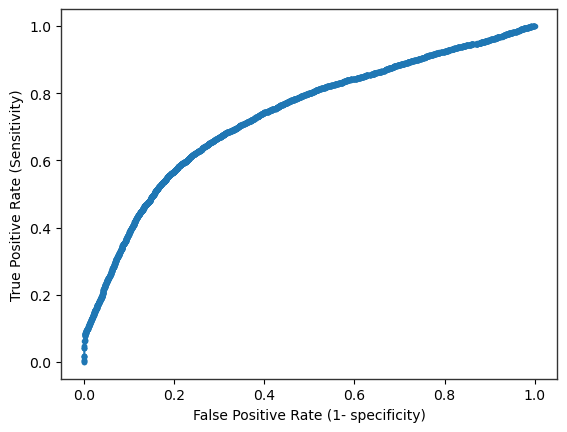

In [ ]:
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate (1- specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

### 5.1.1 ROC Analysis of Binary Classifier (Youden’s J statistic)

In [ ]:
j_statistic = tpr - fpr
optimal_index = np.argmax(j_statistic)
optimal_threshold = thresholds[optimal_index]
optimal_threshold

0.5025354656429575

In [ ]:
ind = np.where(np.isclose(thresholds, optimal_threshold, atol=0.001))
print(tpr[ind])
print(1-fpr[ind])

[0.61536906 0.61617796 0.61617796 0.61658241 0.61658241 0.61718908
 0.61718908 0.6173913  0.6173913  0.61779575 0.61779575 0.61799798
 0.61799798 0.61860465 0.61860465 0.6190091  0.6190091  0.61921132]
[0.75802087 0.75802087 0.75763433 0.75763433 0.75744105 0.75744105
 0.75724778 0.75724778 0.75686123 0.75686123 0.75570158 0.75570158
 0.75550831 0.75550831 0.75473521 0.75473521 0.75454194 0.75454194]


### 5.1.2 ROC Analysis of Binary Classifier (Kolmogorov–Smirnov statistic)

In [ ]:
ks_statistic = np.max(tpr - fpr)
ks_threshold = thresholds[np.argmax(tpr - fpr)]
ks_threshold

0.5025354656429575

In [ ]:
ind = np.where(np.isclose(thresholds, ks_threshold, atol=0.001))
print(tpr[ind])
print(1-fpr[ind])

[0.61536906 0.61617796 0.61617796 0.61658241 0.61658241 0.61718908
 0.61718908 0.6173913  0.6173913  0.61779575 0.61779575 0.61799798
 0.61799798 0.61860465 0.61860465 0.6190091  0.6190091  0.61921132]
[0.75802087 0.75802087 0.75763433 0.75763433 0.75744105 0.75744105
 0.75724778 0.75724778 0.75686123 0.75686123 0.75570158 0.75570158
 0.75550831 0.75550831 0.75473521 0.75473521 0.75454194 0.75454194]


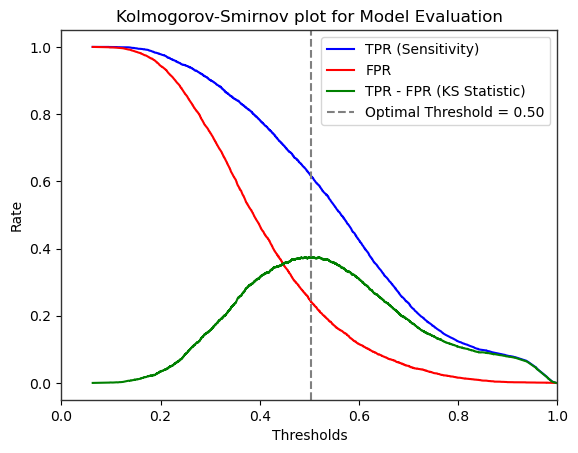

In [ ]:
plt.plot(thresholds, tpr, label='TPR (Sensitivity)', color='blue')
plt.plot(thresholds, fpr, label='FPR', color='red')
plt.plot(thresholds, tpr - fpr, label='TPR - FPR (KS Statistic)', color='green')
plt.axvline(x=ks_threshold, color='grey', linestyle='--', label=f'Optimal Threshold = {ks_threshold:.2f}')
plt.title('Kolmogorov-Smirnov plot for Model Evaluation')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.legend()
plt.xlim([0.0, 1.0])
#plt.gca().invert_xaxis()
plt.show()

The area under the ROC curve (AUC) is around 73% indicates that the model has good
discriminatory power. From the result of Youden’s J statistics and Kolmogorov-Smirnov statistics,
the optimal probability cut-off point is at around 0.5

In [ ]:
# Create a data frame with predicted probabilities (for default) and the class labels in the test set.
df_logit = pd.DataFrame(
data = {'prob0': pred_prob[:,1], 'y_test': y_test}
)
# Use cutoff = threshold and compute misclassification error, sensitivity, and specificity.
df_logit['y_test_pred'] = df_logit.prob0.map(lambda x: 1 if x>ks_threshold else 0)

In [ ]:
cm = confusion_matrix(df_logit.y_test, df_logit.y_test_pred)
print('Confusion Matrix : \n', cm)
total = sum(sum(cm))
accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

Confusion Matrix : 
 [[3916 1258]
 [1891 3054]]
Accuracy :  0.6888032414270184


In [ ]:
sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Sensitivity : ', sensitivity)
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : ', specificity )

Sensitivity :  0.6175935288169868
Specificity :  0.7568612292230382


Using all features from the dataset, the ROC curve illustrates the trade-off between sensitivity
(true positive rate) and specificity (true negative rate). The logistic regression model achieves an
accuracy of 68.8% at the optimal threshold.

## 5.2 logistic regression (PCA feature set)

In [ ]:
from sklearn.linear_model import LogisticRegression
def_log = LogisticRegression(max_iter = 500)
def_log.fit(X_train_final_pca, y_train)

LogisticRegression(max_iter=500)

In [ ]:
pred_prob = def_log.predict_proba(X_test_final_pca)
df_pro = pd.DataFrame(data = {'prob': pred_prob[:,1], 'y_test': y_test})
df_pro.head(5)

prob  y_test
870923   0.094755       0
489902   0.374826       0
108442   0.448476       1
869683   0.252279       0
1031666  0.351458       0

In [ ]:
df_logit = pd.DataFrame(
data = {'prob0': pred_prob[:,1], 'y_test': y_test}
)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(df_logit.y_test, df_logit.prob0)

In [ ]:
# AUC
roc_auc_score(df_logit.y_test, df_logit.prob0)

0.7159304729293196

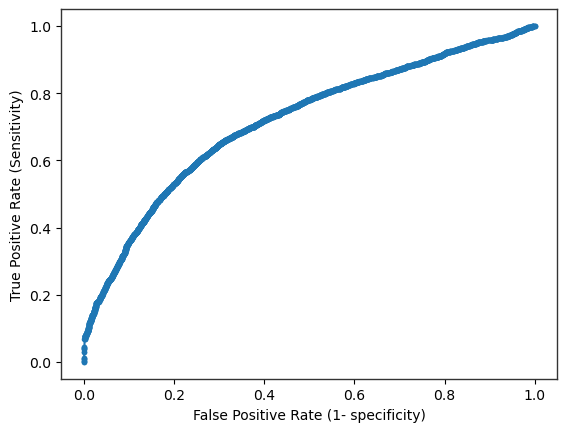

In [ ]:
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate (1- specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

### 5.1.1 ROC Analysis of Binary Classifier (Youden’s J statistic)

In [ ]:
j_statistic = tpr - fpr
optimal_index = np.argmax(j_statistic)
optimal_threshold = thresholds[optimal_index]
optimal_threshold

0.4803313177794514

In [ ]:
ind = np.where(np.isclose(thresholds, optimal_threshold, atol=0.001))
print(tpr[ind])
print(1-fpr[ind])

[0.64509606 0.64529828 0.64529828 0.64610718 0.64610718 0.64691608
 0.64691608 0.64732053 0.64732053 0.64752275 0.64752275 0.64772497
 0.64772497 0.6479272  0.6479272  0.64812942 0.64812942 0.64853387
 0.64853387 0.6487361  0.6487361  0.64893832]
[0.7011983  0.7011983  0.70100503 0.70100503 0.7004252  0.7004252
 0.70003865 0.70003865 0.69984538 0.69984538 0.69965211 0.69965211
 0.69868574 0.69868574 0.69829919 0.69829919 0.69810591 0.69810591
 0.69791264 0.69791264 0.69771937 0.69771937]


### 5.1.2 ROC Analysis of Binary Classifier (Kolmogorov–Smirnov statistic)

In [ ]:
ks_statistic = np.max(tpr - fpr)
ks_threshold = thresholds[np.argmax(tpr - fpr)]
ks_threshold

0.4803313177794514

In [ ]:
ind = np.where(np.isclose(thresholds, ks_threshold, atol=0.001))
print(tpr[ind])
print(1-fpr[ind])

[0.64509606 0.64529828 0.64529828 0.64610718 0.64610718 0.64691608
 0.64691608 0.64732053 0.64732053 0.64752275 0.64752275 0.64772497
 0.64772497 0.6479272  0.6479272  0.64812942 0.64812942 0.64853387
 0.64853387 0.6487361  0.6487361  0.64893832]
[0.7011983  0.7011983  0.70100503 0.70100503 0.7004252  0.7004252
 0.70003865 0.70003865 0.69984538 0.69984538 0.69965211 0.69965211
 0.69868574 0.69868574 0.69829919 0.69829919 0.69810591 0.69810591
 0.69791264 0.69791264 0.69771937 0.69771937]


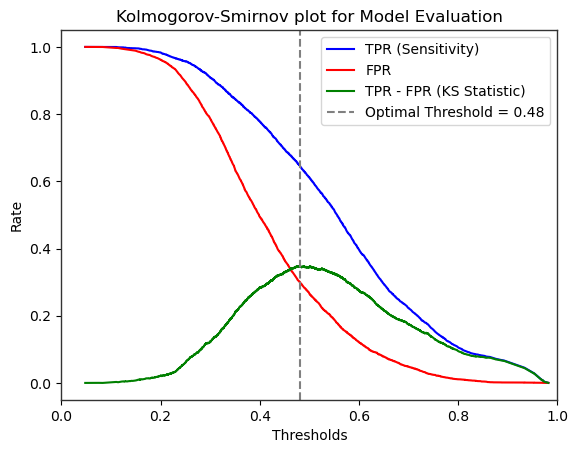

In [ ]:
plt.plot(thresholds, tpr, label='TPR (Sensitivity)', color='blue')
plt.plot(thresholds, fpr, label='FPR', color='red')
plt.plot(thresholds, tpr - fpr, label='TPR - FPR (KS Statistic)', color='green')
plt.axvline(x=ks_threshold, color='grey', linestyle='--', label=f'Optimal Threshold = {ks_threshold:.2f}')
plt.title('Kolmogorov-Smirnov plot for Model Evaluation')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.legend()
plt.xlim([0.0, 1.0])
#plt.gca().invert_xaxis()
plt.show()

The area under the ROC curve (AUC) is around 71% indicates that the model has good
discriminatory power. From the result of Youden’s J statistics and Kolmogorov-Smirnov statistics,
the optimal probability cut-off point is at around 0.48

In [ ]:
# Create a data frame with predicted probabilities (for default) and the class labels in the test set.
df_logit = pd.DataFrame(
data = {'prob0': pred_prob[:,1], 'y_test': y_test}
)
# Use cutoff = threshold and compute misclassification error, sensitivity, and specificity.
df_logit['y_test_pred'] = df_logit.prob0.map(lambda x: 1 if x>ks_threshold else 0)

In [ ]:
cm = confusion_matrix(df_logit.y_test, df_logit.y_test_pred)
print('Confusion Matrix : \n', cm)
total = sum(sum(cm))
accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

Confusion Matrix : 
 [[3620 1554]
 [1743 3202]]
Accuracy :  0.6741772902460718


In [ ]:
sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Sensitivity : ', sensitivity)
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : ', specificity )

Sensitivity :  0.6475227502527806
Specificity :  0.6996521066872826


Using all features from the dataset, the ROC curve illustrates the trade-off between sensitivity
(true positive rate) and specificity (true negative rate). The logistic regression model achieves an
accuracy of 68.8% at the optimal threshold.

## 5.3 Random Forest (final feature set 1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': list(range(50, 200, 50)), 
    'max_depth': [None] + list(range(10, 30, 10)),
    'min_samples_split': [2, 5, 10] 
}

rf = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_finalset1, y_train)
print("best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   6.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   6.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   6.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   8.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   8.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  14.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  14.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  14.6s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   8.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=  22.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=  22.9s
[CV] END max_depth=None, min_sam

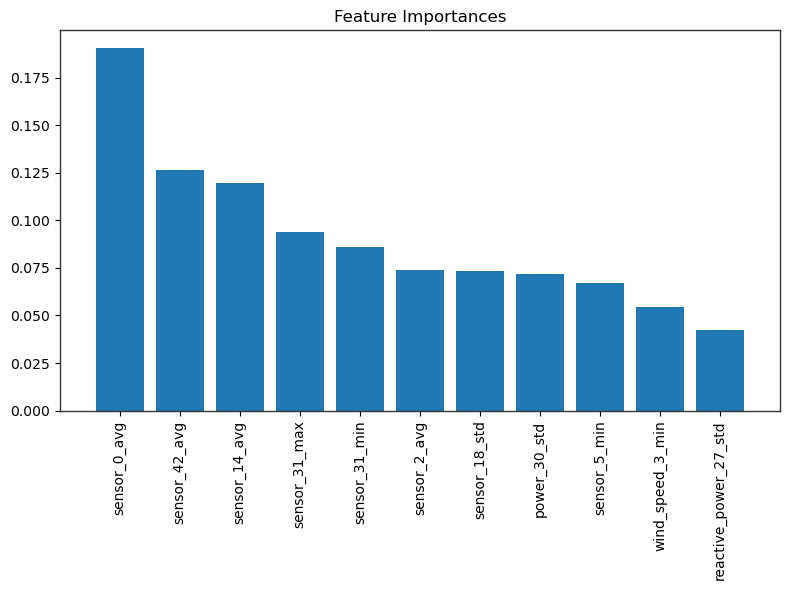

In [ ]:
importances = best_rf.feature_importances_
feature_names = X_train_finalset1.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 6))
plt.title("Feature Importances")
plt.bar(range(X_train_finalset1.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_finalset1.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train_finalset1.shape[1]])
plt.tight_layout()
plt.show()

KS Statistic: 0.7830
Optimal Threshold (KS): 0.5200


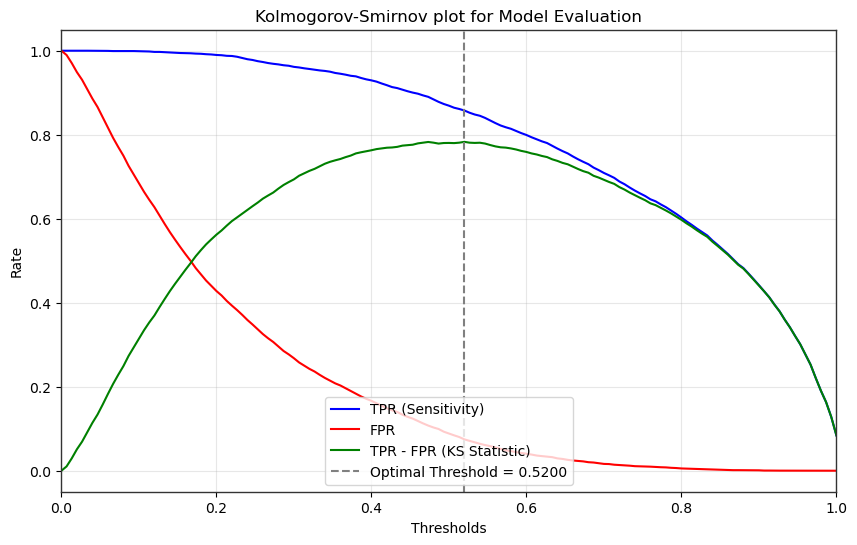

Confusion Matrix (at KS Threshold) : 
 [[4805  369]
 [ 730 4215]]
-------------------------------------------
Accuracy    : 0.8914
Sensitivity : 0.8576
Specificity : 0.9254
-------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix

rf = grid_search.best_estimator_ 
y_test_actual = y_test

pred_prob = rf.predict_proba(X_test_finalset1)
df_rf = pd.DataFrame(data={'prob0': pred_prob[:, 1], 'y_test': y_test_actual})

# calculate KS statistic and optimal threshold
fpr, tpr, thresholds = roc_curve(df_rf.y_test, df_rf.prob0)

ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
ks_threshold = thresholds[ks_idx]

print(f"KS Statistic: {ks_statistic:.4f}")
print(f"Optimal Threshold (KS): {ks_threshold:.4f}")

# plot KS curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr, label='TPR (Sensitivity)', color='blue')
plt.plot(thresholds, fpr, label='FPR', color='red')
plt.plot(thresholds, tpr - fpr, label='TPR - FPR (KS Statistic)', color='green')

plt.axvline(x=ks_threshold, color='grey', linestyle='--', label=f'Optimal Threshold = {ks_threshold:.4f}')

plt.title('Kolmogorov-Smirnov plot for Model Evaluation')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.legend(loc='lower center')
plt.xlim([0.0, 1.0])
plt.grid(True, alpha=0.3)
plt.show()

# 5. use cutoff = threshold and compute misclassification error, sensitivity, and specificity
df_rf['y_test_pred'] = df_rf.prob0.map(lambda x: 1 if x > ks_threshold else 0)

cm = confusion_matrix(df_rf.y_test, df_rf.y_test_pred)
print('Confusion Matrix (at KS Threshold) : \n', cm)

accuracy = np.trace(cm) / np.sum(cm)
ind = np.where(np.isclose(thresholds, ks_threshold, atol=0.001))[0][0]

print('-------------------------------------------')
print(f'Accuracy    : {accuracy:.4f}')
print(f'Sensitivity : {tpr[ind]:.4f}')
print(f'Specificity : {1-fpr[ind]:.4f}')
print('-------------------------------------------')

for all features

In [ ]:
rf_full = RandomForestClassifier(
    n_estimators=150, 
    max_depth=None, 
    min_samples_split=2, 
    n_jobs=-1, 
    random_state=1
)
rf_full.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=1)

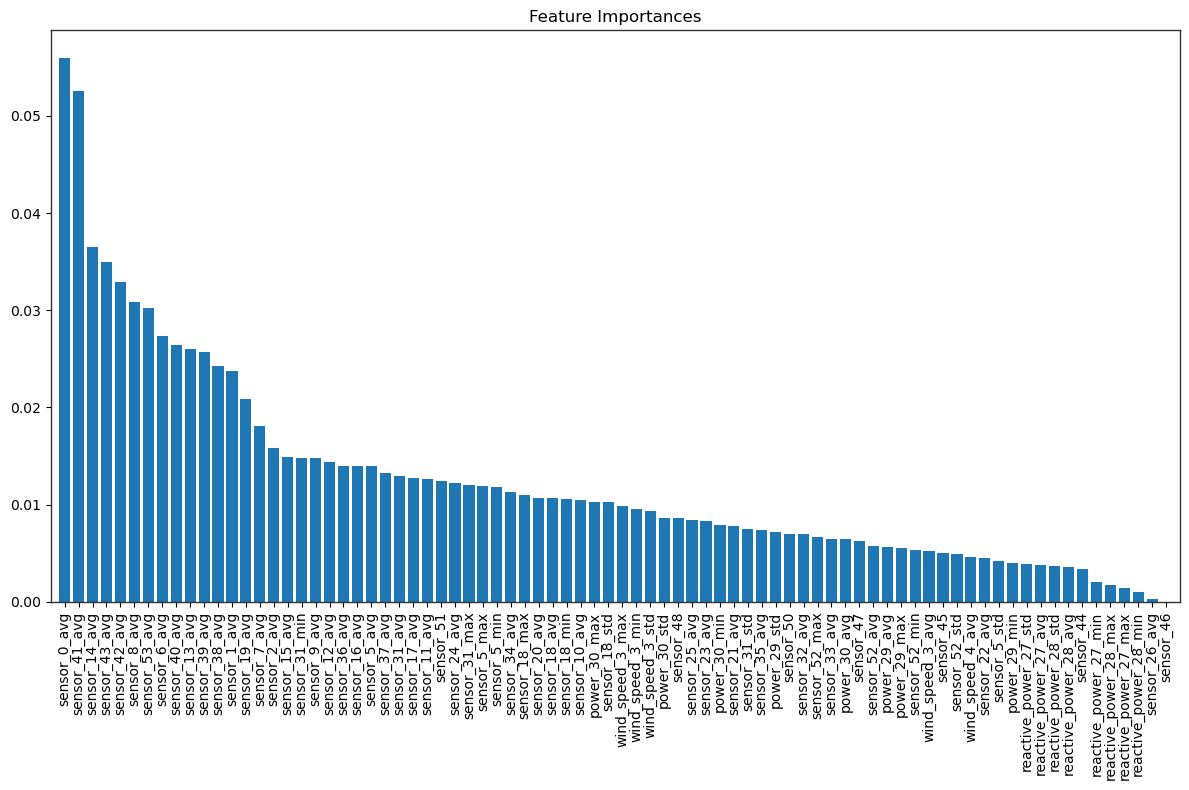

In [ ]:
importances = rf_full.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

KS Statistic: 0.9517
Optimal Threshold (KS): 0.4467


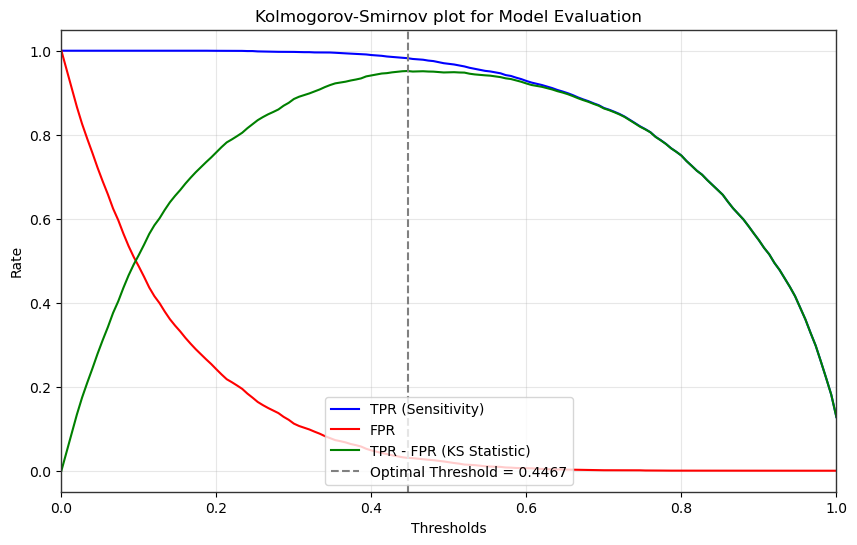

Confusion Matrix (at KS Threshold) : 
 [[5019  155]
 [  97 4848]]
-------------------------------------------
Accuracy    : 0.9751
Sensitivity : 0.9822
Specificity : 0.9695
-------------------------------------------


In [ ]:
y_test_actual = y_test

pred_prob = rf_full.predict_proba(X_test)
df_rf = pd.DataFrame(data={'prob0': pred_prob[:, 1], 'y_test': y_test_actual})

# calculate KS statistic and optimal threshold
fpr, tpr, thresholds = roc_curve(df_rf.y_test, df_rf.prob0)

ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
ks_threshold = thresholds[ks_idx]

print(f"KS Statistic: {ks_statistic:.4f}")
print(f"Optimal Threshold (KS): {ks_threshold:.4f}")

# plot KS curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr, label='TPR (Sensitivity)', color='blue')
plt.plot(thresholds, fpr, label='FPR', color='red')
plt.plot(thresholds, tpr - fpr, label='TPR - FPR (KS Statistic)', color='green')

plt.axvline(x=ks_threshold, color='grey', linestyle='--', label=f'Optimal Threshold = {ks_threshold:.4f}')

plt.title('Kolmogorov-Smirnov plot for Model Evaluation')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.legend(loc='lower center')
plt.xlim([0.0, 1.0])
plt.grid(True, alpha=0.3)
plt.show()

# 5. use cutoff = threshold and compute misclassification error, sensitivity, and specificity
df_rf['y_test_pred'] = df_rf.prob0.map(lambda x: 1 if x > ks_threshold else 0)

cm = confusion_matrix(df_rf.y_test, df_rf.y_test_pred)
print('Confusion Matrix (at KS Threshold) : \n', cm)

accuracy = np.trace(cm) / np.sum(cm)
ind = np.where(np.isclose(thresholds, ks_threshold, atol=0.001))[0][0]

print('-------------------------------------------')
print(f'Accuracy    : {accuracy:.4f}')
print(f'Sensitivity : {tpr[ind]:.4f}')
print(f'Specificity : {1-fpr[ind]:.4f}')
print('-------------------------------------------')

Feature ranking:
1. feature sensor_0_avg (0.0560)
2. feature sensor_41_avg (0.0526)
3. feature sensor_14_avg (0.0366)
4. feature sensor_43_avg (0.0350)
5. feature sensor_42_avg (0.0329)
6. feature sensor_8_avg (0.0308)
7. feature sensor_53_avg (0.0302)
8. feature sensor_6_avg (0.0274)
9. feature sensor_40_avg (0.0264)
10. feature sensor_13_avg (0.0260)


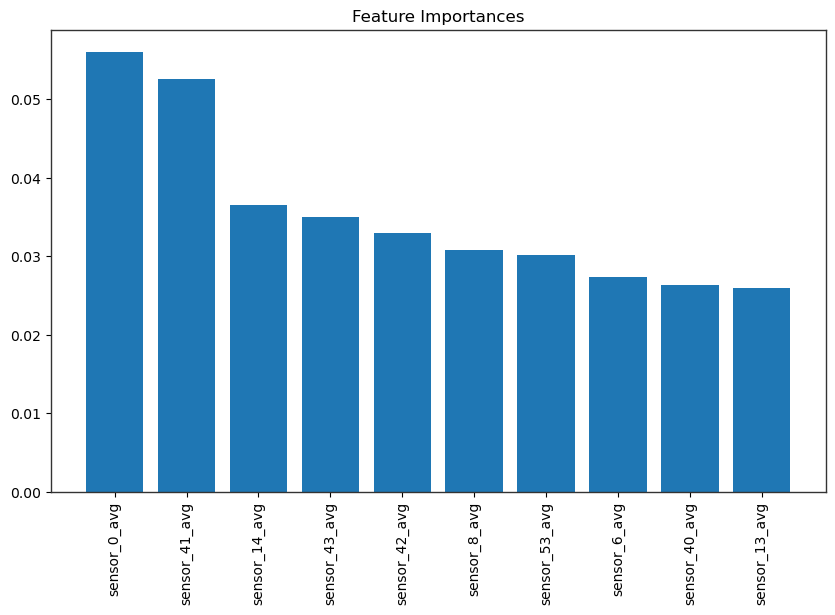

In [ ]:
importances = rf_full.feature_importances_

feature_names = X_train.columns 
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(10): 
    if f < len(feature_names):
        print(f"{f + 1}. feature {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), feature_names[indices[:10]], rotation=90)
plt.show()

Feature importance analysis shows a balanced distribution (top feature < 6%), ruling out data leakage. The high model performance (97.5% Accuracy) is achieved through the ensemble power of Random Forest and the optimization of the classification threshold using the KS statistic

In [ ]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(rf_full, max_features=15, threshold=-np.inf, prefit=True)

X_train_rf_selected = selector.transform(X_train)
X_test_rf_selected = selector.transform(X_test)

selected_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_indices]
print(f"Random Forest selects Top {len(selected_features)} features: {list(selected_features)}")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_rf_scaled = scaler.fit_transform(X_train_rf_selected)
X_test_rf_scaled = scaler.transform(X_test_rf_selected)

lr_rf = LogisticRegression(max_iter=1000, random_state=1)
lr_rf.fit(X_train_rf_scaled, y_train)

acc = lr_rf.score(X_test_rf_scaled, y_test)
print(f"Logistic Regression (using RF features) Accuracy: {acc:.4f}")

Random Forest 挑选的 Top 15 特征: ['sensor_0_avg', 'sensor_1_avg', 'sensor_6_avg', 'sensor_7_avg', 'sensor_8_avg', 'sensor_13_avg', 'sensor_14_avg', 'sensor_19_avg', 'sensor_38_avg', 'sensor_39_avg', 'sensor_40_avg', 'sensor_41_avg', 'sensor_42_avg', 'sensor_43_avg', 'sensor_53_avg']
Logistic Regression (使用 RF 特征) Accuracy: 0.6862


To investigate whether the superior performance of Random Forest was due to feature selection or model architecture, we extracted the top 15 features identified by Random Forest and trained a Logistic Regression model on this subset.

Surprisingly, despite using the most discriminative features (as ranked by RF), the Logistic Regression model yielded an accuracy of only 68.6%, significantly lower than the Random Forest's 97.5%.

This discrepancy highlights a critical characteristic of the dataset: Intrinsic Non-linearity.
The features selected by Random Forest (e.g., sensor_0_avg) likely exhibit non-monotonic relationships with the target variable (e.g., threshold-based failures) or complex high-order interactions (e.g., failure occurs only when Sensor A is high AND Sensor B is low). Random Forest captures these patterns through hierarchical splitting, whereas Logistic Regression is constrained by its linear decision boundary. Therefore, the complexity of this sensor data necessitates the use of non-linear machine learning algorithms over traditional linear statistical methods.

Despite using the most informative features identified by Random Forest, the Logistic Regression accuracy plateaued at 68%. This confirms that the superior performance of the full Random Forest model (97.5%) is driven by its intrinsic capability to model non-linear decision boundaries and feature interactions, which a linear classifier cannot capture regardless of the feature subset.

1. Model Efficiency & Occam's Razor

While the full-feature model (80 features) achieved the highest accuracy (97.5%), the reduced model (10 features) maintained a robust accuracy of 90% with significantly lower computational complexity. This demonstrates that the top 10 features capture the majority of the variance in the dataset

2. Business/Operational Value

From an operational perspective, relying on 80 sensors increases the risk of system failure (e.g., sensor malfunction) and data processing latency. The 10-feature model offers a more viable solution for real-time monitoring, trading a marginal loss in accuracy for enhanced system reliability and interpretability.

3. Methodological Discussion

It is observed that the feature selection techniques applied (VIF, LASSO, Correlation) are primarily linear. The drop in accuracy (from 97.5% to 90%) suggests that the Random Forest model was leveraging non-linear interactions present in the omitted features. Future work could involve non-linear feature selection methods (e.g., Permutation Importance or SHAP) to better preserve these interactions.

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)


In [64]:
#Build and train an ANN using Set1 features
print("X_train_finalset1 shape:", X_train_finalset1.shape)
print("X_test_finalset1 shape :", X_test_finalset1.shape)

# Build an ANN model (with two hidden layers: 64 and 32 neurons)
ann_set1 = Pipeline([
    ("scaler", StandardScaler()),   # standardization first
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64, 32),   # Two hidden layers
        activation="relu",
        solver="adam",
        alpha=1e-4,           # L2 regularization to prevent overfitting
        batch_size=128,
        learning_rate_init=1e-3,
        max_iter=300,
        early_stopping=True,  # Use part of the training data for validation and apply early stopping automatically
        n_iter_no_change=15,
        random_state=1
    ))
])

# Train the model
ann_set1.fit(X_train_finalset1, y_train)

# Make predictions on the test set: labels & probabilities
y_pred_set1 = ann_set1.predict(X_test_finalset1)
y_prob_set1 = ann_set1.predict_proba(X_test_finalset1)[:, 1]


X_train_finalset1 shape: (40474, 11)
X_test_finalset1 shape : (10119, 11)


In [65]:
#Calculate the basic evaluation metrics of the ANN (Set1 features)

acc_set1 = accuracy_score(y_test, y_pred_set1)
auc_set1 = roc_auc_score(y_test, y_prob_set1)

print("=== ANN with Set1 features ===")
print(f"Accuracy: {acc_set1:.3f}")
print(f"ROC-AUC : {auc_set1:.3f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred_set1))


=== ANN with Set1 features ===
Accuracy: 0.813
ROC-AUC : 0.901

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      5174
           1       0.83      0.78      0.80      4945

    accuracy                           0.81     10119
   macro avg       0.81      0.81      0.81     10119
weighted avg       0.81      0.81      0.81     10119



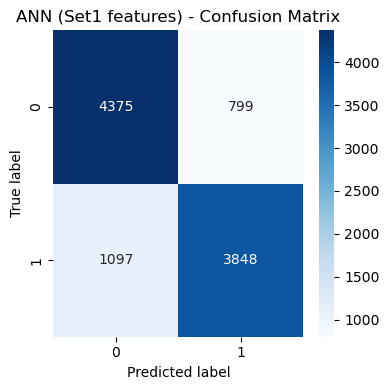

In [66]:
# Plot the Confusion Matrix

cm1 = confusion_matrix(y_test, y_pred_set1)

plt.figure(figsize=(4, 4))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("ANN (Set1 features) - Confusion Matrix")
plt.tight_layout()
plt.show()


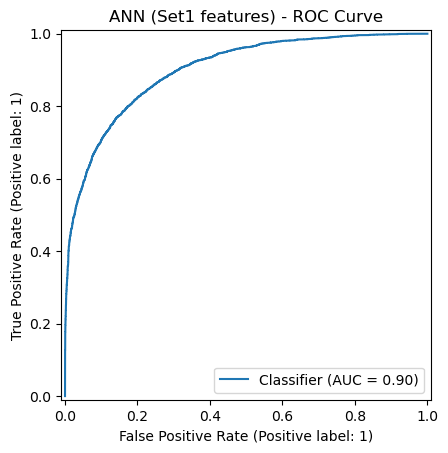

In [67]:
# Plot the ROC curve

RocCurveDisplay.from_predictions(y_test, y_prob_set1)
plt.title("ANN (Set1 features) - ROC Curve")
plt.show()


Artificial Neural Network (ANN) results using the LASSO-selected feature set (Set1)
To capture non-linear interactions among turbine sensor measurements, we trained a feed-forward ANN using the Set1 feature set (11 engineered features after IV, correlation filtering, VIF screening, and LASSO selection). The network architecture consists of two hidden layers with 64 and 32 neurons respectively, ReLU activation, and a sigmoid output unit. Standardization was applied through a pipeline, and the model was optimized using the Adam optimizer with early stopping and L2 regularization to prevent overfitting.
On the held-out test set, the ANN achieved an accuracy of 0.813 and a ROC-AUC of 0.901, indicating strong discriminative ability between normal and faulty operating states. The model correctly identified 3,848 out of 4,945 faulty cases, corresponding to a recall of 0.78 for the fault class, while producing 799 false alarms among normal samples. The confusion matrix and ROC curve further confirm that the ANN learns a stable and meaningful separation between the two classes.
Overall, the ANN demonstrates robust performance and successfully captures complex patterns in the turbine sensor data. Future improvements may focus on adjusting the decision threshold or incorporating class weighting to increase fault recall in safety-critical scenarios.

In [68]:
# Check the dimension of PCA features
print("X_train_final_pca shape:", X_train_final_pca.shape)
print("X_test_final_pca shape :", X_test_final_pca.shape)


X_train_final_pca shape: (40474, 12)
X_test_final_pca shape : (10119, 12)


In [69]:
# Build and train an ANN using PCA features

ann_pca = Pipeline([
    ("scaler", StandardScaler()),   # Standardization
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(32, 16),   # Slightly smaller than Set1: 32 → 16
        activation="relu",
        solver="adam",
        alpha=1e-4,
        batch_size=128,
        learning_rate_init=1e-3,
        max_iter=300,
        early_stopping=True,
        n_iter_no_change=15,
        random_state=1
    ))
])

# train the model
ann_pca.fit(X_train_final_pca, y_train)

# Make predictions on the test set: labels & probabilities
y_pred_pca = ann_pca.predict(X_test_final_pca)
y_prob_pca = ann_pca.predict_proba(X_test_final_pca)[:, 1]


In [70]:
# Evaluation metrics of the ANN with PCA features


acc_pca = accuracy_score(y_test, y_pred_pca)
auc_pca = roc_auc_score(y_test, y_prob_pca)

print("=== ANN with PCA features ===")
print(f"Accuracy: {acc_pca:.3f}")
print(f"ROC-AUC : {auc_pca:.3f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred_pca))


=== ANN with PCA features ===
Accuracy: 0.791
ROC-AUC : 0.877

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      5174
           1       0.80      0.77      0.78      4945

    accuracy                           0.79     10119
   macro avg       0.79      0.79      0.79     10119
weighted avg       0.79      0.79      0.79     10119



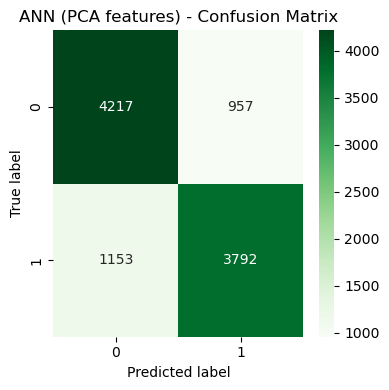

In [72]:
# Confusion Matrix (PCA features)

cm_pca = confusion_matrix(y_test, y_pred_pca)

plt.figure(figsize=(4, 4))
sns.heatmap(cm_pca, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("ANN (PCA features) - Confusion Matrix")
plt.tight_layout()
plt.show()



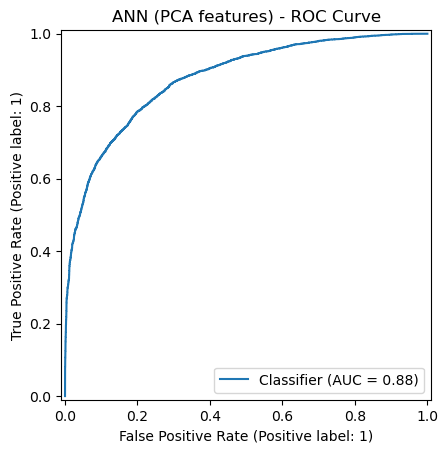

In [73]:
# ROC Curve (PCA features)


RocCurveDisplay.from_predictions(y_test, y_prob_pca)
plt.title("ANN (PCA features) - ROC Curve")
plt.show()


In [74]:
# Result Comparison Table of Set1 vs. PCA

comparison_df = pd.DataFrame({
    "Model": ["ANN - Set1 features", "ANN - PCA features"],
    "Accuracy": [acc_set1, acc_pca],
    "ROC_AUC": [auc_set1, auc_pca]
})

display(comparison_df)


Model  Accuracy   ROC_AUC
0  ANN - Set1 features  0.812630  0.900534
1   ANN - PCA features  0.791481  0.876941

Artificial Neural Network (ANN) using PCA features
We also trained an ANN model using the 12 PCA components derived from the full sensor set. The PCA transformation compresses the original variables into orthogonal components that retain most of the variance but do not necessarily maximize fault separability. A more compact ANN architecture (32 and 16 neurons) was therefore used.
On the test set, the PCA-based ANN achieved an accuracy of 0.791 and a ROC-AUC of 0.877. The model correctly identified 3,792 faulty samples (recall = 0.77) but showed slightly more false alarms (957) and missed faults (1,153) compared with the Set1-based ANN. The ROC curve confirms good discriminative ability, though weaker than the LASSO-selected feature model.
Overall, the PCA-ANN model performs reasonably well and provides a lower-dimensional alternative, but the supervised Set1 features retain more fault-related information and therefore deliver better classification performance.

The ANN trained on Set1 features performs noticeably better than the PCA-based ANN. Set1 achieves 81.3% accuracy and 0.90 AUC, outperforming PCA’s 79.1% accuracy and 0.88 AUC.
The reason is that Set1 contains supervised, fault-related sensor features, while PCA compresses information without considering class separation. As a result, Set1 captures more meaningful fault signals and yields higher detection performance.

In [75]:
#Full features
print(df_feature.shape)

(50593, 80)


In [76]:
# ANN using Full Feature Set

from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay

ann_full = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(128, 64),   
        activation="relu",
        solver="adam",
        alpha=1e-4,
        batch_size=128,
        learning_rate_init=1e-3,
        max_iter=400,
        early_stopping=True,
        n_iter_no_change=20,
        random_state=1
    ))
])

# train
ann_full.fit(X_train, y_train)

# predict
y_pred_full = ann_full.predict(X_test)
y_prob_full = ann_full.predict_proba(X_test)[:, 1]

# Performance indicators
acc_full = accuracy_score(y_test, y_pred_full)
auc_full = roc_auc_score(y_test, y_prob_full)

print("=== ANN with Full Features ===")
print(f"Accuracy: {acc_full:.3f}")
print(f"ROC-AUC : {auc_full:.3f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred_full))


=== ANN with Full Features ===
Accuracy: 0.978
ROC-AUC : 0.998

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5174
           1       0.98      0.98      0.98      4945

    accuracy                           0.98     10119
   macro avg       0.98      0.98      0.98     10119
weighted avg       0.98      0.98      0.98     10119



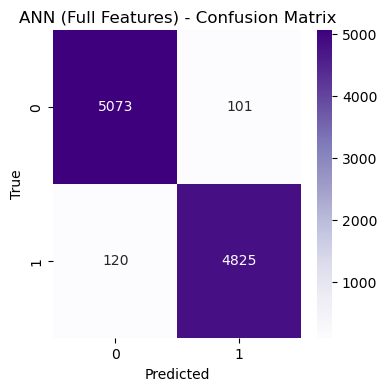

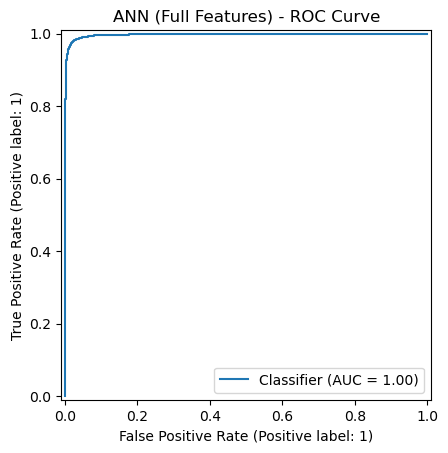

In [77]:
cm_full = confusion_matrix(y_test, y_pred_full)
plt.figure(figsize=(4,4))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ANN (Full Features) - Confusion Matrix")
plt.show()


RocCurveDisplay.from_predictions(y_test, y_prob_full)
plt.title("ANN (Full Features) - ROC Curve")
plt.show()


In [78]:
print(df_feature.corrwith(df_target).sort_values(ascending=False).head(10))


sensor_0_avg     0.232218
sensor_43_avg    0.229558
sensor_5_avg     0.204428
sensor_5_min     0.200354
sensor_41_avg    0.196595
sensor_5_max     0.180780
sensor_53_avg    0.179191
sensor_19_avg    0.162626
sensor_7_avg     0.143688
sensor_14_avg    0.137903
dtype: float64


/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
